### FINM33150 - Quant Trading Strategies
## Homework 3
## University of Chicago


### Author: Laurent Lanteigne
### ID: 12279717
### Date: April 22nd, 2021

 # 1. Data

In [77]:
%matplotlib inline
pd.set_option("precision", 4)

In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import scipy as sp
import random
import quandl
import datetime as dt
import functools
import seaborn as sns
import plotnine as p9
import os
from tqdm import tqdm
import copy
import time
from scipy.stats import norm
import statsmodels.api as sm
plt.style.use('fivethirtyeight')

quandl_key = os.environ.get('QUANDL_API_KEY') # Works now, might need to reset env or computer to have it work 

In [3]:
import warnings

import pandas as pd
from pandas.core.common import SettingWithCopyWarning

warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)

In [4]:
try:
    # Do not recreate if it already exists
    fetch_quandl_table
    print("fetch_quandl_table already defined")
except NameError:
    @functools.lru_cache(maxsize=16)
    def fetch_quandl_table(table, cols):
        print("Fetching from Quandl")
        qdata = quandl.get_table(table, paginate = True,
                                 per_end_date={'gte':'2012-05-31', 'lte':'2020-04-31'}, 
                                 qopts = {"columns":cols.split()}, api_key = quandl_key)
        temp_table = table.split('/')[-1]
        qdata.to_hdf(temp_table+'.df', temp_table+'data', mode = 'w')
        return pd.read_hdf(temp_table+'.df', temp_table+'data')
    print("fetch_quandl has now been newly defined")

fetch_quandl has now been newly defined


### Grabbing the information needed from the different tables.

In [5]:
z_tables = []
for t in "FC FR MKTV SHRS".split():
    z_tables.append('ZACKS/'+t)
    
z_cols = [["zacks_sector_code","net_lterm_debt","tot_lterm_debt", "eps_diluted_net","basic_net_eps", "filing_date","per_type"],
          ["tot_debt_tot_equity","ret_invst","per_type"],
          ["mkt_val"],
          ["shares_out"]]
dic_tables = {}
for count, table in enumerate(z_tables):
    lst = ["ticker", "m_ticker"]
    for c in z_cols[count]:
        lst.append(c)
    lst.append("per_end_date")
    dic_tables[table] = lst

In [6]:
dfs = []
for table, cols in dic_tables.items():
    dataframe_str = 'df'+'_'+ table.split('/')[-1].lower()
    globals()[dataframe_str] = fetch_quandl_table(table, " ".join(cols))
    dfs.append(globals()[dataframe_str])
    
dfs.to_pickle('zacls_data.pkl')

Fetching from Quandl
Fetching from Quandl
Fetching from Quandl
Fetching from Quandl


### Cleaning up DataFrame with list of tickers we have information from 2013 going through end of 2019 with quarterly data for simplification

In [7]:
for i in range(2):
    dfs[i] = dfs[i][dfs[i]['per_type'] == 'Q']
    dfs[i].drop('per_type',inplace=True, axis=1)
for i in range(4):
    mask = (dfs[i]['per_end_date'].groupby(dfs[i]['m_ticker']).min() < '2012-09-30') & (dfs[i]['per_end_date'].groupby(dfs[i]['m_ticker']).max() >= '2019-12-31')
    list_tickers = list(mask.index[mask == True])
    dfs[i] = dfs[i][dfs[i]['m_ticker'].isin(list_tickers)]
    

### Checking shape and null values in the dfs

In [8]:
merge_df = dfs[0]
for df in dfs:
    print(str(df.shape) +'\t' + str(df.isnull().sum().sum()))
    if id(df) != id(dfs[0]):
        merge_df = merge_df.merge(df, on = ['ticker','m_ticker','per_end_date'], how = 'outer')

(141729, 9)	167569
(141729, 5)	35596
(123379, 4)	0
(138397, 4)	296


### Lets drop rows where there is null values and see what our merged dataframe looks like 

In [9]:
print(merge_df.dropna().shape)
merge_df.dropna(inplace = True)
merge_df.head(10)

(52252, 13)


,ticker,m_ticker,zacks_sector_code,net_lterm_debt,tot_lterm_debt,eps_diluted_net,basic_net_eps,filing_date,per_end_date,tot_debt_tot_equity,ret_invst,mkt_val,shares_out
113,AAIC,FBG,13.0,24.038,40.000,0.19,0.19,2013-08-02,2013-06-30,3.3580,0.5501,442.89,16.56
114,AAIC,FBG,13.0,24.038,40.000,0.18,0.19,2013-11-01,2013-09-30,3.0477,0.5430,394.89,16.61
115,AAIC,FBG,13.0,24.038,40.000,2.66,2.40,2014-02-10,2013-12-31,2.8770,7.3263,438.10,16.60
120,AAIC,FBG,13.0,34.188,75.300,-1.84,-1.84,2015-05-06,2015-03-31,6.0417,-6.5319,552.59,22.97
121,AAIC,FBG,13.0,34.063,75.300,0.29,0.29,2015-07-31,2015-06-30,6.7971,1.0635,449.14,22.96
122,AAIC,FBG,13.0,342.563,383.800,-2.29,-2.29,2015-11-02,2015-09-30,7.4006,-6.1069,323.61,23.03
123,AAIC,FBG,13.0,820.963,860.333,0.82,0.82,2016-02-16,2015-12-31,7.6340,1.3992,303.99,22.98
124,AAIC,FBG,13.0,-786.900,73.489,-1.38,-1.38,2016-05-10,2016-03-31,7.2310,-6.2343,287.90,22.98
125,AAIC,FBG,13.0,-786.900,73.545,0.56,0.56,2016-08-05,2016-06-30,7.8387,2.5481,298.87,22.97
126,AAIC,FBG,13.0,-786.900,73.601,0.81,0.82,2016-11-04,2016-09-30,7.9470,3.7049,340.63,23.03


In [10]:
industry_filt_df = merge_df[(merge_df['zacks_sector_code'] != 13) & (merge_df['zacks_sector_code'] != 5)]
industry_filt_df['debt_to_mktval'] = industry_filt_df['tot_lterm_debt'] / industry_filt_df['mkt_val']
debt_filt_df = industry_filt_df[industry_filt_df['debt_to_mktval'] > 0.1]
debt_filt_df.dropna(inplace=True)

print("Dataframe shape = {}".format(debt_filt_df.shape))
print("Unique tickers = {}".format(len(debt_filt_df['m_ticker'].unique())))
debt_filt_df.head(10)

Dataframe shape = (27270, 14)
Unique tickers = 1415


,ticker,m_ticker,zacks_sector_code,net_lterm_debt,tot_lterm_debt,eps_diluted_net,basic_net_eps,filing_date,per_end_date,tot_debt_tot_equity,ret_invst,mkt_val,shares_out,debt_to_mktval
269,AAP,AAP2,3.0,299.904,599.696,1.3400,1.3600,2012-08-20,2012-06-30,0.5669,6.0047,5015.13,73.51,0.119577
270,AAP,AAP2,3.0,299.904,599.550,1.2100,1.2200,2012-11-13,2012-09-30,0.5231,5.1232,5018.57,73.33,0.119466
271,AAP,AAP2,3.0,299.904,604.461,0.8800,0.8900,2013-02-25,2012-12-31,0.4998,3.5840,5307.88,73.36,0.113880
275,AAP,AAP2,3.0,448.605,1052.668,0.6600,0.6800,2014-02-25,2013-12-31,0.6949,1.9178,8061.05,72.83,0.130587
300,AAP,AAP2,3.0,498.240,1241.094,0.6300,0.6300,2020-05-19,2020-03-31,0.4922,0.9122,6447.43,69.09,0.192494
316,AAPL,AAPL,10.0,15584.000,69374.000,0.4750,0.4775,2016-04-27,2016-03-31,0.6122,5.2624,597096.25,21913.80,0.116186
317,AAPL,AAPL,10.0,15484.000,68939.000,0.3550,0.3575,2016-07-27,2016-06-30,0.6712,3.9881,515134.84,21553.76,0.133827
318,AAPL,AAPL,10.0,22454.000,75427.000,0.4275,0.4200,2016-10-26,2016-09-30,0.6786,4.4257,609163.13,21553.76,0.123821
320,AAPL,AAPL,10.0,10975.000,84531.000,0.5250,0.5275,2017-05-03,2017-03-31,0.7348,5.0450,753717.88,20986.16,0.112152
321,AAPL,AAPL,10.0,18225.000,89864.000,0.4175,0.4200,2017-08-02,2017-06-30,0.8181,3.9215,750897.25,20855.36,0.119675


### Because we just did more filtering some of our tickers now do not have sufficient data. So let's filter some more.

In [11]:
mask = (debt_filt_df['per_end_date'].groupby(debt_filt_df['m_ticker']).min() < '2012-09-30') & (debt_filt_df['per_end_date'].groupby(debt_filt_df['m_ticker']).max() >= '2019-12-31')
list_tickers = list(mask.index[mask == True])
debt_filt_df = debt_filt_df[debt_filt_df['m_ticker'].isin(list_tickers)]

In [12]:
print("Dataframe shape = {}".format(debt_filt_df.shape))
print("Unique tickers = {}".format(len(debt_filt_df['m_ticker'].unique())))
debt_filt_df.head(10)

Dataframe shape = (17774, 14)
Unique tickers = 625


,ticker,m_ticker,zacks_sector_code,net_lterm_debt,tot_lterm_debt,eps_diluted_net,basic_net_eps,filing_date,per_end_date,tot_debt_tot_equity,ret_invst,mkt_val,shares_out,debt_to_mktval
269,AAP,AAP2,3.0,299.904,599.696,1.34,1.36,2012-08-20,2012-06-30,0.5669,6.0047,5015.13,73.51,0.119577
270,AAP,AAP2,3.0,299.904,599.550,1.21,1.22,2012-11-13,2012-09-30,0.5231,5.1232,5018.57,73.33,0.119466
271,AAP,AAP2,3.0,299.904,604.461,0.88,0.89,2013-02-25,2012-12-31,0.4998,3.5840,5307.88,73.36,0.113880
275,AAP,AAP2,3.0,448.605,1052.668,0.66,0.68,2014-02-25,2013-12-31,0.6949,1.9178,8061.05,72.83,0.130587
300,AAP,AAP2,3.0,498.240,1241.094,0.63,0.63,2020-05-19,2020-03-31,0.4922,0.9122,6447.43,69.09,0.192494
461,AAWW,AAWW,15.0,147.401,808.004,1.16,1.17,2012-08-02,2012-06-30,0.7562,1.5613,1149.62,26.42,0.702844
462,AAWW,AAWW,15.0,292.396,910.520,1.27,1.28,2012-11-01,2012-09-30,0.8515,1.6163,1365.10,26.44,0.666999
463,AAWW,AAWW,15.0,548.933,1149.282,1.98,1.98,2013-02-13,2012-12-31,1.0124,2.1746,1171.95,26.44,0.980658
464,AAWW,AAWW,15.0,154.273,1229.416,0.76,0.76,2013-05-02,2013-03-31,1.1599,0.8081,1077.82,26.44,1.140651
465,AAWW,AAWW,15.0,266.163,1330.345,0.78,0.78,2013-08-01,2013-06-30,1.2593,0.8128,1130.28,25.83,1.177005


Here we observe that some tickers don't have all the information from the beginning of 2013 to 2020. Since we need 7 years of data with 4 quarterly updates we need tickers with at least 28 counts in the dataframe.

In [13]:
mask = (debt_filt_df['m_ticker'].value_counts() >= 28)
list_tickers = list(mask.index[mask == True])
debt_filt_df = debt_filt_df[debt_filt_df['m_ticker'].isin(list_tickers)]

In [14]:
print("Dataframe shape = {}".format(debt_filt_df.shape))
print("Unique tickers = {}".format(len(debt_filt_df['m_ticker'].unique())))
debt_filt_df.head(10)

Dataframe shape = (14344, 14)
Unique tickers = 458


,ticker,m_ticker,zacks_sector_code,net_lterm_debt,tot_lterm_debt,eps_diluted_net,basic_net_eps,filing_date,per_end_date,tot_debt_tot_equity,ret_invst,mkt_val,shares_out,debt_to_mktval
461,AAWW,AAWW,15.0,147.401,808.004,1.16,1.17,2012-08-02,2012-06-30,0.7562,1.5613,1149.62,26.42,0.702844
462,AAWW,AAWW,15.0,292.396,910.520,1.27,1.28,2012-11-01,2012-09-30,0.8515,1.6163,1365.10,26.44,0.666999
463,AAWW,AAWW,15.0,548.933,1149.282,1.98,1.98,2013-02-13,2012-12-31,1.0124,2.1746,1171.95,26.44,0.980658
464,AAWW,AAWW,15.0,154.273,1229.416,0.76,0.76,2013-05-02,2013-03-31,1.1599,0.8081,1077.82,26.44,1.140651
465,AAWW,AAWW,15.0,266.163,1330.345,0.78,0.78,2013-08-01,2013-06-30,1.2593,0.8128,1130.28,25.83,1.177005
466,AAWW,AAWW,15.0,338.388,1473.685,0.94,0.94,2013-11-07,2013-09-30,1.3490,0.8955,1161.89,25.24,1.268352
467,AAWW,AAWW,15.0,297.313,1539.139,1.18,1.20,2014-02-13,2013-12-31,1.2833,0.9856,1030.35,25.04,1.493802
468,AAWW,AAWW,15.0,420.865,1923.694,0.32,0.32,2014-05-01,2014-03-31,1.5991,0.1239,883.13,25.04,2.178268
469,AAWW,AAWW,15.0,371.531,1876.961,1.17,1.17,2014-07-31,2014-06-30,1.5276,0.8965,929.80,25.23,2.018672
470,AAWW,AAWW,15.0,320.003,1829.148,1.10,1.10,2014-11-06,2014-09-30,1.4727,0.8614,834.02,25.26,2.193170


In [17]:
tickers = debt_filt_df['ticker'].unique()

# 2. EOD Data

We'll build a dictionary of dataframes for each ticker

In [18]:
tickers_data = {}
error_ticker = []
for tick in tqdm(tickers):
    o_tick = tick
    if len(tick.split('.')) > 1:
        tick = tick.split('.')[0]+'_'+tick.split('.')[1]
    tick = 'EOD/' + tick
    try:
        data = quandl.get(tick, returns="pandas",api_key = quandl_key, start_date = '2012-09-30', end_date = '2020-01-31')
        tickers_data[o_tick] = data.rename_axis("Date")
    except:
        error_ticker.append(tick)
tickers_data.to_pickle('tickers_data.pkl')

100%|████████████████████████████████████████████████████████████████████████████████| 458/458 [07:35<00:00,  1.01it/s]


In [20]:
print("Number of Error Quandl Requests = {}".format(len(error_ticker)))
print(len(tickers_data))
print(tickers_data[tickers[0]].shape[0])

Number of Error Quandl Requests = 2
456
1845


Let's now find the number of trading days to only select those stocks where we have all the daily prices.

In [21]:
trading_days = []
for k,v in tickers_data.items():
    trading_days.append(v.shape[0])
max_trading_days = np.array(trading_days).max()
max_trading_days

1845

In [22]:
df_tickers = {}
valid_tickers = []
for k,v in tickers_data.items():
    if v.shape[0] == max_trading_days:
        df_tickers[k] = v
        valid_tickers.append(k)

In [23]:
for ticker, df in tqdm(df_tickers.items()):
    """
    ZACKS FUNDAMENTAL DATAFRAME
    """
    # Making sure in order
    temp_df = debt_filt_df[debt_filt_df['ticker']==ticker].sort_values(by=['filing_date'])
    # Drops columns won't be of any help anymore
    temp_df.drop(['m_ticker', 'zacks_sector_code', 'per_end_date'], inplace = True, axis = 1)
    # Filter by dates in order to have information we need for the dates we need 
    first_idx = temp_df.index[temp_df['filing_date'] < '2013-01-01'][-1]
    last_idx = temp_df.index[temp_df['filing_date']< '2020-01-31'][-1]
    temp_df = temp_df.loc[first_idx:last_idx]
    # Reindex 
    temp_df.set_index(['filing_date'], inplace = True)
    
    """
    JOINING ZACKS DF WITH EOD DATAFRAME AND CLEANING DF
    """
    trading_idx = df.index
    df = df[['Adj_Close']].merge(temp_df,how='outer',left_index=True, right_index=True) 
    # Fill database forward from values from filing date
    df = df.fillna(method='ffill')
    # We only want to keep the trading dates in the index now 
    df = df.loc[(trading_idx,)]
    # Fix market value that is on wrong date, simply shares time price per share 
    df.mkt_val = df.Adj_Close * df.shares_out
    # fix negative eps with 0.001 
    df.basic_net_eps = np.where(df.basic_net_eps <= 0, 0.001, df.basic_net_eps)
    df.eps_diluted_net = np.where(np.isnan(df.eps_diluted_net), df.basic_net_eps, df.eps_diluted_net)
    df.eps_diluted_net = np.where(df.eps_diluted_net <= 0, 0.001, df.eps_diluted_net)

    # compute earnings 
    df['earnings'] = df['eps_diluted_net'] * df['shares_out']
    # reduce our dataframe for only the dates we care about 
    df = df.loc['2013':'2020-01-31']
    # fix debt to market with the daily market value 
    df['debt_to_mktval'] = df['tot_lterm_debt'] / df['mkt_val']
    # compute roi 
    df['roi'] = (df.earnings)/(df.net_lterm_debt + df.mkt_val)

    # compute price per earnings with diluted if we have all values otherwise use basic 
    df['pe'] = df.mkt_val/df.earnings
    features_wanted = ['Adj_Close','ticker','tot_debt_tot_equity','ret_invst','debt_to_mktval','roi','pe']
    df_tickers[ticker] = df[features_wanted]
df_tickers.to_pickle('df_tickers.pkl')

100%|████████████████████████████████████████████████████████████████████████████████| 429/429 [00:06<00:00, 63.80it/s]


Now that we have the right dataframe for security, we'll select 200 random tickers in the dictionary of securities and merge them into one big dataframe.

In [24]:
np.random.seed(0)
random_tickers = random.sample(range(len(valid_tickers)), len(valid_tickers))
tickers_df_arr = []
count = 0
while len(tickers_df_arr) < 200:
    tf = df_tickers[valid_tickers[random_tickers[count]]].rename_axis('Date')
    # This is to make sure we have the right number of data
    # Number is smaller since we truncated the dataframes
    if len(tf) == 1783:
        tf = tf.reset_index().set_index(['Date','ticker'])
        tickers_df_arr.append(tf)
    count +=1 
        

df = pd.concat(tickers_df_arr).dropna()
print("Dataframe shape = {}".format(df.shape))
df.head()

Dataframe shape = (356600, 6)


,,Adj_Close,tot_debt_tot_equity,ret_invst,debt_to_mktval,roi,pe
Date,ticker,,,,,,
2013-01-02,ANTM,53.857214,0.6,1.8575,0.764864,0.032936,25.049867
2013-01-03,ANTM,52.097925,0.6,1.8575,0.790693,0.033848,24.231593
2013-01-04,ANTM,52.416188,0.6,1.8575,0.785892,0.033679,24.379623
2013-01-07,ANTM,52.814018,0.6,1.8575,0.779972,0.033471,24.564659
2013-01-08,ANTM,53.105759,0.6,1.8575,0.775687,0.033319,24.700353


In [25]:
df.describe()

,Adj_Close,tot_debt_tot_equity,ret_invst,debt_to_mktval,roi,pe
count,356600.000000,356600.000000,356600.000000,356600.000000,356600.000000,356600.000000
mean,46.427925,0.711264,1.281837,0.884269,0.017216,6019.786502
std,61.298366,73.677045,4.204698,1.797424,2.857150,31613.292526
min,0.196400,-4754.571000,-107.453900,0.053618,-341.227257,0.333333
25%,16.390000,0.645900,0.410000,0.281448,0.004560,49.028441
50%,31.341609,1.020300,1.357700,0.494373,0.012541,78.822770
75%,54.972396,1.662800,2.479500,0.914223,0.020169,212.872680
max,1267.611755,2131.513000,51.880600,62.680623,602.532780,968257.839356


We have some really high P/E from data with negative or no EPS. Let's see what our data looks like for a day

In [26]:
df.loc[('2013-01-02',)]

,Adj_Close,tot_debt_tot_equity,ret_invst,debt_to_mktval,roi,pe
ticker,,,,,,
ANTM,53.857214,0.6000,1.8575,0.764864,0.032936,25.049867
GATX,35.411924,3.0260,1.0905,2.232693,0.032390,31.337986
CIDM,13.500000,-55.6011,-1.2656,3.243555,0.000117,13500.000000
CAH,33.487214,0.4584,3.1304,0.211171,0.023599,42.388879
IBM,144.583323,1.5539,8.3111,0.147270,0.022408,43.418415
...,...,...,...,...,...,...
SENEA,31.580000,0.9138,2.3191,0.749700,0.031379,25.885246
PATK,7.338759,0.5738,7.3021,0.184729,0.036344,27.516908
CVA,11.922091,2.2818,0.8758,1.324886,0.015867,62.747845


For each day we are going to compute a q-score for each ticker based on the universe of the 200 tickers available via equal weight to each financial metric and one with random weights to each financial metrics and compare the result of our trading strategy later. We'll assume that we want a low debt/equity, high ret_investm, low debt_to_mktval, high row, low pe 

In [83]:
df['quantile_even'] = np.nan
df['quantile_rand'] = np.nan
rank_features = 'debt/equity_rank ret/invst_rank debt/mkt_rank roi_rank pe_rank'.split()
for feature in rank_features:
    df[feature] = np.nan


In [28]:
features = [df.columns[i] for i in range(1,6)]

# uniform and random weights normalized 
w_unif = np.ones(len(features))/len(features)
w_rand = np.random.uniform(0,1,len(features))
w_rand /= sum(w_rand)
    
for date in tqdm(df.index.get_level_values('Date').unique()):
    # compute percentiles for each features
    q_arr = [] 
    for count, feat in enumerate(features):
        if feat not in ['tot_debt_tot_equity','debt_to_mktval','pe']:
            q_arr.append(df.loc[(date,)][feat].rank(pct=True))
            df.loc[(date,)][rank_features[count]] = df.loc[(date,)][feat].rank(pct=True)
        else:
            q_arr.append(df.loc[(date,)][feat].rank(pct=True, ascending = False))
            df.loc[(date,)][rank_features[count]] = df.loc[(date,)][feat].rank(pct=True, ascending = False)
    # multiply the matrix of percentiles with the weight vectors for custom quantiles 
    df.loc[(date,)]['quantile_even'] = np.matrix(q_arr).T @ w_unif.reshape(5,1)
    df.loc[(date,)]['quantile_rand'] = np.matrix(q_arr).T @ w_rand.reshape(5,1)
    
    # rank the score we get for each date with customized selection 
    df.loc[(date,)]['quantile_even'] = df.loc[(date,)]['quantile_even'].rank(pct=True)
    df.loc[(date,)]['quantile_rand'] = df.loc[(date,)]['quantile_rand'].rank(pct=True)
features.to_pickle('features.pkl')

100%|██████████████████████████████████████████████████████████████████████████████| 1783/1783 [01:36<00:00, 18.43it/s]


Let's print some information about the dataframe with securities ranked for each date. We have 7 different ranking systems, 5 of which are single ratio and the other 2 are a combination of them, one of which is equally weighted and the other is random.

In [29]:
df.describe()

,Adj_Close,tot_debt_tot_equity,ret_invst,debt_to_mktval,roi,pe,quantile_even,quantile_rand,debt/equity_rank,ret/invst_rank,debt/mkt_rank,roi_rank,pe_rank
count,356600.000000,356600.000000,356600.000000,356600.000000,356600.000000,356600.000000,356600.00000,356600.000000,356600.000000,356600.000000,356600.000000,356600.000000,356600.000000
mean,46.427925,0.711264,1.281837,0.884269,0.017216,6019.786502,0.50250,0.502500,0.502500,0.502500,0.502500,0.502500,0.502500
std,61.298366,73.677045,4.204698,1.797424,2.857150,31613.292526,0.28867,0.288672,0.288672,0.288672,0.288672,0.288672,0.288672
min,0.196400,-4754.571000,-107.453900,0.053618,-341.227257,0.333333,0.00500,0.005000,0.005000,0.005000,0.005000,0.005000,0.005000
25%,16.390000,0.645900,0.410000,0.281448,0.004560,49.028441,0.25250,0.253750,0.252500,0.252500,0.253750,0.253750,0.253750
50%,31.341609,1.020300,1.357700,0.494373,0.012541,78.822770,0.50250,0.502500,0.502500,0.502500,0.502500,0.502500,0.502500
75%,54.972396,1.662800,2.479500,0.914223,0.020169,212.872680,0.75250,0.751250,0.752500,0.752500,0.751250,0.751250,0.751250
max,1267.611755,2131.513000,51.880600,62.680623,602.532780,968257.839356,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [30]:
df.head(10)

,,Adj_Close,tot_debt_tot_equity,ret_invst,debt_to_mktval,roi,pe,quantile_even,quantile_rand,debt/equity_rank,ret/invst_rank,debt/mkt_rank,roi_rank,pe_rank
Date,ticker,,,,,,,,,,,,,
2013-01-02,ANTM,53.857214,0.6,1.8575,0.764864,0.032936,25.049867,0.800,0.760,0.775,0.545,0.330,0.875,0.920
2013-01-03,ANTM,52.097925,0.6,1.8575,0.790693,0.033848,24.231593,0.800,0.760,0.775,0.545,0.320,0.875,0.925
2013-01-04,ANTM,52.416188,0.6,1.8575,0.785892,0.033679,24.379623,0.790,0.760,0.775,0.545,0.320,0.875,0.925
2013-01-07,ANTM,52.814018,0.6,1.8575,0.779972,0.033471,24.564659,0.795,0.760,0.775,0.545,0.330,0.875,0.915
2013-01-08,ANTM,53.105759,0.6,1.8575,0.775687,0.033319,24.700353,0.810,0.760,0.775,0.545,0.330,0.875,0.920
2013-01-09,ANTM,54.856207,0.6,1.8575,0.750935,0.032439,25.514515,0.795,0.760,0.775,0.545,0.330,0.875,0.910
2013-01-10,ANTM,55.024179,0.6,1.8575,0.748643,0.032357,25.592641,0.800,0.760,0.775,0.545,0.330,0.875,0.905
2013-01-11,ANTM,54.590987,0.6,1.8575,0.754583,0.032570,25.391157,0.805,0.760,0.775,0.545,0.330,0.875,0.915
2013-01-14,ANTM,55.200992,0.6,1.8575,0.746245,0.032271,25.674880,0.805,0.760,0.775,0.545,0.335,0.870,0.910


Update our ranking features

In [84]:
rank_features += 'quantile_even quantile_rand'.split()

Let's grab the index for weekly, and monthly trading day.

In [32]:
daily_idx = copy.deepcopy(tickers_data[tickers[0]])['2013':'2020-01-31'].index
weekly_idx = []
monthly_idx = []
curr_month = 0 
for i in range(len(daily_idx)):
    if i == 0:
        weekly_idx.append(daily_idx[i])
        monthly_idx.append(daily_idx[i])
        curr_month = daily_idx[i].month
    else:
        # Here we assume no trading break in the middle of the week, given more time I'd add conditions to make sure it is really is a new calendar week 
        # We get a new week when the difference between today and last trading day is >1 
        if (daily_idx[i]-daily_idx[i-1]).days > 1:
            weekly_idx.append(daily_idx[i])
        if daily_idx[i].month != curr_month:
            monthly_idx.append(daily_idx[i])
            curr_month = daily_idx[i].month      

# 3. Trading Strategy

Now that we have our quantiles done and our trading index. Let's implement a trading strategy. We will be distributing 25% of gross notional on top 5%, 25% on 20-5%, similar for shorting. 

In [33]:
tickers_idx = df.index.get_level_values('ticker').unique()
iterables = [tickers_idx, ['Adj_Close','Shares','Position']]
col = pd.MultiIndex.from_product(iterables, names=["Tickers", "Portfolio"])

In [34]:
trading_df = pd.DataFrame(index = daily_idx, columns = col)
port_col = "Net_Pos Gross PnL PnL_accumulated Cash Capital".split()
for col in port_col:
    trading_df['Portfolio',col] = np.nan

In [35]:
for ticker in tickers_idx:
    trading_df[[(ticker,'Adj_Close')]] = df.xs(ticker,level='ticker').Adj_Close
trading_df.fillna(0, inplace=True)
starting_capital = 1e5
trading_df[('Portfolio','Cash')].iloc[0] = starting_capital
trading_df[('Portfolio','Capital')].iloc[0] = starting_capital
max_trade_size = trading_df[('Portfolio','Capital')].iloc[0]/10
trading_df.head()

In [118]:
TRADING_SKELETON_DF = copy.deepcopy(trading_df)

In [36]:
starting_capital = 1e5

In [37]:
rank_feature = rank_features[0]
for date in tqdm(daily_idx):
    yst_date = daily_idx.get_loc(date) - 1
    if date in monthly_idx:
        # Grab index that will be traded 
        top_5_pct = df.loc[(date,)][df.loc[(date,)][rank_feature] > 0.95].index
        top_20_pct = df.loc[(date,)][(df.loc[(date,)][rank_feature] <= 0.95) & (df.loc[(date,)][rank_feature] > 0.80)].index
        bottom_20_pct = df.loc[(date,)][(df.loc[(date,)][rank_feature] <= 0.20) & (df.loc[(date,)][rank_feature] > 0.05)].index
        bottom_5_pct = df.loc[(date,)][(df.loc[(date,)][rank_feature] <= 0.05) ].index
#         if date == monthly_idx[0]:
#             # Checking right number of tickers for the date 
#             print(len(top_5_pct), len(top_20_pct), len(bottom_20_pct), len(bottom_5_pct))
#             # it works 
        q_counter = 0 
        master_idx = []
        # For group we greated 
        for quantile in [top_5_pct,top_20_pct,bottom_20_pct,bottom_5_pct]:
            q_counter +=1 
            for ticker in quantile:
                master_idx.append(ticker)
                # Trade volume equally distributed among each quantile
                trade_val = 0.25*max_trade_size/len(quantile)
                # Shorting the bottom
                if q_counter > 2:
                    sign = 1 
                else:
                    sign = -1
                trading_df[(ticker,'Shares')].loc[date] = sign * int(trade_val/trading_df[(ticker,'Adj_Close')].loc[date])
                trading_df[(ticker,'Position')].loc[date] = trading_df[(ticker,'Adj_Close')].loc[date] * trading_df[(ticker,'Shares')].loc[date]
    else:
        #Given no trading activity, the shares are simply what they were previous days
        for ticker in tickers_idx: 
            trading_df[(ticker,'Shares')].loc[date] = trading_df[(ticker,'Shares')].iloc[yst_date]
            trading_df[(ticker,'Position')].loc[date] = trading_df[(ticker,'Adj_Close')].loc[date] * trading_df[(ticker,'Shares')].loc[date]
trading_v1_df.to_pickle('trading_v1_df.pkl')

100%|██████████████████████████████████████████████████████████████████████████████| 1783/1783 [17:18<00:00,  1.72it/s]


In [38]:
# Debug purposes
try:
    trading_df_copy
    print("Copy already defined")
except NameError:
    trading_df_copy = copy.deepcopy(trading_df)

In [39]:
# Debug purposes
trading_df = copy.deepcopy(trading_df_copy)

In [40]:
# Need to keep working with vectorization, much faster and elegant than date by date like above, but I was running out of time and other assignments due this week 
# and it's easier conceptually to do date by date for trading conditions.
trading_df[('Portfolio','Net_Pos')] = trading_df.T.xs('Position',level=('Portfolio')).sum()
trading_df[('Portfolio','Gross')] = trading_df.T.xs('Position',level=('Portfolio')).apply(abs).sum()
trading_df[('Portfolio','PnL')] = trading_df[('Portfolio','Net_Pos')] - trading_df[('Portfolio','Net_Pos')].shift(1)
for i, date in enumerate(monthly_idx):
    first_m_date = monthly_idx[i-1]
    # PnL trading day is 0 
    trading_df[('Portfolio','PnL')].loc[date] = 0
    
    # Update Cash 
    if i != 0:
        # On last day before the upcoming trading_day
        yst_date = daily_idx.get_loc(date) - 1
        # Update Cash at the end of month being the difference between what we initially had and our net position
       # trading_df[('Portfolio','Cash')].iloc[yst_date] +=  trading_df.groupby(pd.Grouper(freq='M')).sum()[('Portfolio','PnL')].iloc[i-1]
        trading_df[('Portfolio','Cash')].loc[daily_idx[yst_date]] +=  trading_df[('Portfolio','Cash')].loc[first_m_date] + trading_df[('Portfolio','Net_Pos')].loc[daily_idx[yst_date]]
        # Update Cash first trading day as being the cash you had yesterday minus the net position trade you  did 
        trading_df[('Portfolio','Cash')].loc[date] = trading_df[('Portfolio','Cash')].loc[daily_idx[yst_date]] - trading_df[('Portfolio','Net_Pos')].loc[date]
    else:
        #If it's first trading day, cash is what we start with - net position we took 
        trading_df[('Portfolio','Cash')].loc[date] = trading_df[('Portfolio','Cash')].loc[date] - trading_df[('Portfolio','Net_Pos')].loc[date]
    
     
trading_df[('Portfolio','PnL_accumulated')] = trading_df[('Portfolio','PnL')].cumsum()
trading_df[('Portfolio','Cash')] = trading_df[('Portfolio','Cash')].replace(to_replace=0, method='ffill')
trading_df = trading_df.fillna(0)
#sloppy code but closing our book at the end for cash
trading_df[('Portfolio','Cash')].loc['2020-01-31'] += (trading_df[('Portfolio','Net_Pos')].loc['2020-01-31']) - (trading_df[('Portfolio','Net_Pos')].loc['2020-01-02'])
trading_df.head(30)

Tickers          ANTM                       GATX                        CIDM  \
Portfolio   Adj_Close Shares Position  Adj_Close Shares   Position Adj_Close   
Date                                                                           
2013-01-02  53.857214      0      0.0  35.411924      2  70.823849      13.5   
2013-01-03  52.097925      0      0.0  35.371757      2  70.743513      13.9   
2013-01-04  52.416188      0      0.0  36.030508      2  72.061017      14.4   
2013-01-07  52.814018      0      0.0  36.199213      2  72.398426      13.9   
2013-01-08  53.105759      0      0.0  36.070676      2  72.141352      13.8   
2013-01-09  54.856207      0      0.0  36.641059      2  73.282118      14.0   
2013-01-10  55.024179      0      0.0  36.689260      2  73.378520      13.7   
2013-01-11  54.590987      0      0.0  37.098972      2  74.197943      13.9   
2013-01-14  55.200992      0      0.0  36.890099      2  73.780198      14.1   
2013-01-15  55.704909      0      0.0  37.315878      2  74.631755      13.6   
2013-01-16  54.679394      0      0.0  36.914200      2  73.828400      13.9   
2013-01-17  55.183311      0      0.0  37.468515      2  74.937031      14.0   
2013-01-18  55.475052      0      0.0  37.348012      2  74.696024      13.9   
2013-01-22  56.403320      0      0.0  37.669354      2  75.338709      14.6   
2013-01-23  57.313906      0      0.0  37.733623      2  75.467245      13.6   
2013-01-24  58.074202      0      0.0  37.508683      2  75.017366      13.8   
2013-01-25  58.498553      0      0.0  37.066837      2  74.133675      13.6   
2013-01-28  58.401306      0      0.0  37.773791      2  75.547581      14.7   
2013-01-29  58.304058      0      0.0  37.605086      2  75.210172      14.7   
2013-01-30  57.808982      0      0.0  37.789858      2  75.579715      15.2   
2013-01-31  57.305066      0      0.0  38.038898      2  76.077796      15.8   
2013-02-01  57.747098      0      0.0  38.858321      2  77.716642      16.0   
2013-02-04  57.305066      0      0.0  38.569113      2  77.138226      15.9   
2013-02-05  58.206811      0      0.0  38.737817      2  77.475635      15.9   
2013-02-06  57.826664      0      0.0  38.761918      2  77.523836      15.1   
2013-02-07  58.083042      0      0.0  39.107361      2  78.214722      15.4   
2013-02-08  58.595800      0      0.0  39.332301      2  78.664602      15.5   
2013-02-11  58.357102      0      0.0  39.565274      2  79.130548      15.4   
2013-02-12  58.357102      0      0.0  39.725945      2  79.451890      15.9   
2013-02-13  55.696068      0      0.0  40.135657      2  80.271313      15.5   

Tickers                           CAH  ...      SWX        TDS         \
Portfolio  Shares Position  Adj_Close  ... Position  Adj_Close Shares   
Date                                   ...                              
2013-01-02    -18   -243.0  33.487214  ...      0.0  18.779897     -4   
2013-01-03    -18   -250.2  33.567539  ...      0.0  19.190655     -4   
2013-01-04    -18   -259.2  34.097679  ...      0.0  19.297453     -4   
2013-01-07    -18   -250.2  34.081614  ...      0.0  19.281022     -4   
2013-01-08    -18   -248.4  34.081614  ...      0.0  18.870263     -4   
2013-01-09    -18   -252.0  34.250295  ...      0.0  18.911339     -4   
2013-01-10    -18   -246.6  34.531431  ...      0.0  18.968846     -4   
2013-01-11    -18   -250.2  34.587658  ...      0.0  18.993491     -4   
2013-01-14    -18   -253.8  34.692079  ...      0.0  18.599163     -4   
2013-01-15    -18   -244.8  34.933052  ...      0.0  18.558087     -4   
2013-01-16    -18   -250.2  35.125831  ...      0.0  18.352707     -4   
2013-01-17    -18   -252.0  35.471225  ...      0.0  18.377353     -4   
2013-01-18    -18   -250.2  35.856782  ...      0.0  19.223516     -4   
2013-01-22    -18   -262.8  35.800555  ...      0.0  19.363174     -4   
2013-01-23    -18   -244.8  36.194144  ...      0.0  20.135401     -4   
2013-01-24    -18   -248.4  35.929074  ...   

Notice how on the last day of the month we close our position, take the cash. Next day we spend whatever is needed to optain new position and we have 0 PnL on that day.
Libor rate from FRED StLouis Fed : 
https://fred.stlouisfed.org/series/USD3MTD156N

In [41]:
# Upload and clean LIBOR
libor_rate = pd.read_csv("USD3MTD156N.csv", index_col = 'DATE')
libor_rate = libor_rate.replace(to_replace= '.', method='ffill')
libor_rate["USD3MTD156N"] = pd.to_numeric(libor_rate["USD3MTD156N"])
libor_rate['repo'] = libor_rate["USD3MTD156N"] - 1

idx = pd.to_datetime(libor_rate.index)
libor_rate.set_index(idx, inplace = True)
# Grab trading index and add the repo column in trading dataframe 
libor_rate = libor_rate[libor_rate.index.isin(trading_df.index)]
trading_df['repo'] = libor_rate['repo']
trading_df['borrow_cost'] = 0
curr_borrow = 0
for i, date in tqdm(enumerate(daily_idx)):
    yst_date = daily_idx.get_loc(date) - 1
    if date in monthly_idx:
        # Borrow amount is the difference between the short and the long position
        curr_borrow = trading_df[('Portfolio','Net_Pos')].loc[date]
    else:
        # We use Libor 3M - 100bps for the instateneous short rate so the cost of borrow is N(np.exp(r*(deltat)))-N, where N is the borrowed/lent amount
        delta_time = (daily_idx[i] - daily_idx[yst_date]).days/365
        trading_df.loc[date,'borrow_cost'] = curr_borrow * (np.exp(trading_df['repo'].iloc[yst_date]*delta_time)-1)

trading_df['borrow_cost'] = trading_df['borrow_cost'].cumsum()
trading_df[('Portfolio', 'Cash')] = trading_df[('Portfolio', 'Cash')] - trading_df['borrow_cost']
trading_df[('Portfolio','Capital')] = trading_df[('Portfolio','Cash')] + trading_df[('Portfolio','PnL_accumulated')] + trading_df[('Portfolio','Net_Pos')]
trading_df[('Portfolio','PnL_accumulated')] = trading_df[('Portfolio','PnL_accumulated')] - trading_df['borrow_cost']
#sloppy code again but let's update our new PnL based on previous cash at the end and new cash at the end this time. 
trading_df.tail(30)

1783it [00:03, 508.15it/s]


Tickers           ANTM                       GATX                        CIDM  \
Portfolio    Adj_Close Shares Position  Adj_Close Shares   Position Adj_Close   
Date                                                                            
2019-12-18  288.345473      0      0.0  80.924400      1  80.924400  0.789100   
2019-12-19  293.302364      0      0.0  81.350165      1  81.350165  0.800000   
2019-12-20  298.003542      0      0.0  82.192019      1  82.192019  0.840000   
2019-12-23  298.180573      0      0.0  82.356519      1  82.356519  0.850000   
2019-12-24  299.478807      0      0.0  81.698519      1  81.698519  0.742500   
2019-12-26  299.734519      0      0.0  82.433931      1  82.433931  0.720000   
2019-12-27  301.367146      0      0.0  81.630783      1  81.630783  0.690000   
2019-12-30  300.275450      0      0.0  79.830958      1  79.830958  0.723500   
2019-12-31  297.049537      0      0.0  80.169635      1  80.169635  0.700000   
2020-01-02  295.908665      0      0.0  80.779253      1  80.779253  0.719956   
2020-01-03  291.984460      0      0.0  80.343812      1  80.343812  0.816600   
2020-01-06  295.495591      0      0.0  79.105222      1  79.105222  0.720100   
2020-01-07  294.600597      0      0.0  79.018134      1  79.018134  0.724996   
2020-01-08  302.409667      0      0.0  78.582692      1  78.582692  0.730000   
2020-01-09  301.357311      0      0.0  78.331104      1  78.331104  0.750000   
2020-01-10  302.665379      0      0.0  77.876309      1  77.876309  0.718300   
2020-01-13  291.846769      0      0.0  78.021456      1  78.021456  0.710000   
2020-01-14  291.984460      0      0.0  76.589337      1  76.589337  0.695000   
2020-01-15  296.577452      0      0.0  76.434514      1  76.434514  0.695000   
2020-01-16  300.019737      0      0.0  77.208632      1  77.208632  0.702500   
2020-01-17  300.354131      0      0.0  74.876600      1  74.876600  0.715000   
2020-01-21  300.944237      0      0.0  72.689716      1  72.689716  0.672000   
2020-01-22  298.505132      0      0.0  72.863893      1  72.863893  0.657800   
2020-01-23  299.380456      0      0.0  79.685811      1  79.685811  0.659900   
2020-01-24  292.377864      0      0.0  78.989104      1  78.989104  0.624058   
2020-01-27  279.110314      0      0.0  76.211955      1  76.211955  0.580000   
2020-01-28  285.532634      0      0.0  76.628043      1  76.628043  0.538000   
2020-01-29  268.409725      0      0.0  76.153896      1  76.153896  0.559900   
2020-01-30  261.505484      0      0.0  76.018425      1  76.018425  0.542292   
2020-01-31  260.905543      0      0.0  73.667040      1  73.667040  0.540000   

Tickers                            CAH  ...    TDS              Portfolio  \
Portfolio  Shares  Position  Adj_Close  ... Shares   Position     Net_Pos   
Date                                    ...                                 
2019-12-18   -108 -85.22280  48.316416  ...     -3 -69.942872 -278.435558   
2019-12-19   -108 -86.40000  47.853108  ...     -3 -71.264175 -284.043620   
2019-12-20   -108 -90.72000  48.978285  ...     -3 -71.580139 -258.470853   
2019-12-23   -108 -91.80000  48.344782  ...     -3 -71.292899 -304.551977   
2019-12-24   -108 -80.19000  48.496066  ...     -3 -71.178003 -301.109449   
2019-12-26   -108 -77.76000  48.382603  ...     -3 -71.292899 -294.013867   
2019-12-27   -108 -74.52000  48.694627  ...     -3 -71.407795 -245.865735   
2019-12-30   -108 -78.13800  48.004392  ...     -3 -71.838654 -270.659092   
2019-12-31   -108 -75.60000  48.279635  ...     -3 -73.045061 -309.553514   
2020-01-02   -115 -82.79494  47.811920  ...     -3 -72.614202  100.582223   
2020-01-03   -115 -93.90900  47.115120  ...     -3 -71.924826  128.891824   
2020-01-06   -115 -82.81150  47.506474  ...     -3 -71.608863  103.949656   
2020-01-07   -115 -83.37454  47.525564  ...     -3 -70.316284   64.244200   
2020-01-08   -115 -83.95000  47.783285  ...     -3 -70.862039   60.944840   
2020-01-09   -115

In [42]:
strategy_pnl = trading_df[('Portfolio','PnL_accumulated')][-1]
print("Strategy PnL is equal to: {:.2f}$".format(strategy_pnl))

Strategy PnL is equal to: 1387.22$


Funny enough, when I check the PnL with and without the borrowing, there is a difference of 12$ we made from lending money at repo rate, or because the repo rate was negative at the beginning. 

# 4. More Ranking Features

We've got a strategy that works, now before we explore which best set of ratios we are going to use in our final strategy, let's create a new feature one based on biggest change in quantile.

In [43]:
df['weekly_rank_even'] = np.nan
df['monthly_rank_even'] = np.nan
df['weekly_rank_rand'] = np.nan
df['monthly_rank_ran'] = np.nan
print(df.shape)
df.head()

(356600, 17)


,,Adj_Close,tot_debt_tot_equity,ret_invst,debt_to_mktval,roi,pe,quantile_even,quantile_rand,debt/equity_rank,ret/invst_rank,debt/mkt_rank,roi_rank,pe_rank,weekly_rank_even,monthly_rank_even,weekly_rank_rand,monthly_rank_ran
Date,ticker,,,,,,,,,,,,,,,,,
2013-01-02,ANTM,53.857214,0.6,1.8575,0.764864,0.032936,25.049867,0.800,0.76,0.775,0.545,0.33,0.875,0.920,NaN,NaN,NaN,NaN
2013-01-03,ANTM,52.097925,0.6,1.8575,0.790693,0.033848,24.231593,0.800,0.76,0.775,0.545,0.32,0.875,0.925,NaN,NaN,NaN,NaN
2013-01-04,ANTM,52.416188,0.6,1.8575,0.785892,0.033679,24.379623,0.790,0.76,0.775,0.545,0.32,0.875,0.925,NaN,NaN,NaN,NaN
2013-01-07,ANTM,52.814018,0.6,1.8575,0.779972,0.033471,24.564659,0.795,0.76,0.775,0.545,0.33,0.875,0.915,NaN,NaN,NaN,NaN
2013-01-08,ANTM,53.105759,0.6,1.8575,0.775687,0.033319,24.700353,0.810,0.76,0.775,0.545,0.33,0.875,0.920,NaN,NaN,NaN,NaN


In [44]:
w_temp_df = df.groupby([pd.Grouper(level='Date', freq='W-MON'),'ticker']).first()
m_temp_df = df.groupby([pd.Grouper(level='Date', freq='MS'),'ticker']).first()

for ticker in tqdm(tickers_idx):
    # Group by Week and Tickers take first value of the time period, then for each ticker, take the percentage difference of evenly distributed quantile score or randomly distributed
    # Need to shift weekly for it to make sense sinceon '2013-01-07' it is our second trading week, not first, see below 
    w_temp_df.loc[(slice(None),ticker), 'weekly_rank_even'] = w_temp_df.loc[(slice(None),ticker),'quantile_even'].pct_change().shift(-1)
    m_temp_df.loc[(slice(None),ticker), 'monthly_rank_even'] = m_temp_df.loc[(slice(None),ticker),'quantile_even'].pct_change()
    w_temp_df.loc[(slice(None),ticker), 'weekly_rank_rand'] = w_temp_df.loc[(slice(None),ticker),'quantile_rand'].pct_change().shift(-1)
    m_temp_df.loc[(slice(None),ticker), 'monthly_rank_rand'] = m_temp_df.loc[(slice(None),ticker),'quantile_rand'].pct_change()

w_temp_df = w_temp_df[['weekly_rank_even', 'weekly_rank_rand']].loc[(slice('2013-01-07','2020-01-27'),)]
m_temp_df = m_temp_df[['monthly_rank_even', 'monthly_rank_rand']]

100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:05<00:00, 38.80it/s]


In [46]:
w_temp_df.loc[(slice(None),tickers_idx[0]), :]

,,weekly_rank_even,weekly_rank_rand
Date,ticker,,
2013-01-07,ANTM,0.012500,0.000000
2013-01-14,ANTM,-0.018519,-0.006579
2013-01-21,ANTM,0.012579,0.006623
2013-01-28,ANTM,-0.012422,0.006579
2013-02-04,ANTM,0.006289,-0.006536
...,...,...,...
2019-12-30,ANTM,0.000000,0.000000
2020-01-06,ANTM,0.006410,0.000000
2020-01-13,ANTM,0.000000,0.000000


In [47]:
m_temp_df.loc[(slice(None),tickers_idx[0]), :]

,,monthly_rank_even,monthly_rank_rand
Date,ticker,,
2013-01-01,ANTM,NaN,NaN
2013-02-01,ANTM,-0.006250,0.006579
2013-03-01,ANTM,-0.144654,-0.196078
2013-04-01,ANTM,-0.022059,0.024390
2013-05-01,ANTM,0.270677,0.293651
...,...,...,...
2019-09-01,ANTM,0.015337,0.018405
2019-10-01,ANTM,0.021148,0.012048
2019-11-01,ANTM,-0.026627,-0.017857


In [48]:
all_days = pd.date_range('2013-01-01', '2020-01-31', freq='D')
lst_tuples = []
for day in all_days:
    for ticker in tickers_idx:
        lst_tuples.append((day,ticker))
idx = pd.MultiIndex.from_tuples(lst_tuples, names=('Date','ticker'))
temporary_df = pd.DataFrame(index = idx)
temporary_df['weekly_rank_even'] = np.nan
temporary_df['weekly_rank_rand'] = np.nan
temporary_df['monthly_rank_even'] = np.nan
temporary_df['monthly_rank_rand'] = np.nan

In [49]:
temporary_df

weekly_rank_even  weekly_rank_rand  monthly_rank_even  \
Date       ticker                                                          
2013-01-01 ANTM                 NaN               NaN                NaN   
           GATX                 NaN               NaN                NaN   
           CIDM                 NaN               NaN                NaN   
           CAH                  NaN               NaN                NaN   
           IBM                  NaN               NaN                NaN   
...                             ...               ...                ...   
2020-01-31 SENEA                NaN               NaN                NaN   
           PATK                 NaN               NaN                NaN   
           CVA                  NaN               NaN                NaN   
           SWX                  NaN               NaN                NaN   
           TDS                  NaN               NaN                NaN   

                   monthly_rank_rand  
Date       ticker                     
2013-01-01 ANTM                  NaN  
           GATX                  NaN  
           CIDM                  NaN  
           CAH                   NaN  
           IBM                   NaN  
...                              ...  
2020-01-31 SENEA                 NaN  
           PATK                  NaN  
           CVA                   NaN  
           SWX                   NaN  
           TDS                   NaN  

[517400 rows x 4 columns]

In [50]:
for ticker in tqdm(tickers_idx):
    temporary_df.loc[(slice(None),ticker), ['weekly_rank_even','weekly_rank_rand']] = w_temp_df.loc[(slice(None),ticker), :]
    temporary_df.loc[(slice(None),ticker), ['monthly_rank_even','monthly_rank_rand']] = m_temp_df.loc[(slice(None),ticker), :]

100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:31<00:00,  6.33it/s]


Below simply checking if the values are at the right places, which they are.

In [52]:
temporary_df.loc[('2013-01-14',tickers_idx[0]), :]

,,weekly_rank_even,weekly_rank_rand,monthly_rank_even,monthly_rank_rand
Date,ticker,,,,
2013-01-14,ANTM,-0.018519,-0.006579,NaN,NaN


In [54]:
temporary_df.loc[('2013-05-01',tickers_idx[0]), :]

,,weekly_rank_even,weekly_rank_rand,monthly_rank_even,monthly_rank_rand
Date,ticker,,,,
2013-05-01,ANTM,NaN,NaN,0.270677,0.293651


Now we need to loop through weekly and monthly index and for each compute rank

In [55]:
print(temporary_df.isnull().sum())
for date in w_temp_df.index.get_level_values(0).unique()[1:]:
    temporary_df.loc[(date,)][["weekly_rank_even","weekly_rank_rand"]] = temporary_df.loc[(date,)][["weekly_rank_even","weekly_rank_rand"]].rank(pct=True)
    # Debugging conditions
    if (temporary_df.loc[(date,)][["weekly_rank_even","weekly_rank_rand"]]).isnull().sum().sum() > 0:
        print(date,temporary_df.loc[(date,)][["weekly_rank_even","weekly_rank_rand"]])
        break

for date in m_temp_df.index.get_level_values(0).unique()[1:]:
    temporary_df.loc[(date,)][["monthly_rank_even","monthly_rank_rand"]] = temporary_df.loc[(date,)][["monthly_rank_even","monthly_rank_rand"]].rank(pct=True)
    
    # Debugging conditions
    if (temporary_df.loc[(date,)][["monthly_rank_even","monthly_rank_rand"]]).isnull().sum().sum() > 0:
        print(date,temporary_df.loc[(date,)][["monthly_rank_even","monthly_rank_rand"]])
        break
# We want same number of null to make sure all we did is replace existing values with their rank 
print(temporary_df.isnull().sum())
# Now that we have all ranked the weekly and monthly trading dates, let's fill forward the ranking to each day in between trading dates 
for ticker in tqdm(tickers_idx):
    temporary_df.loc[(slice(None),ticker), :] = temporary_df.loc[(slice(None),ticker), :].fillna(method ='ffill')
    
temporary_df.describe()

weekly_rank_even     443600
weekly_rank_rand     443600
monthly_rank_even    500600
monthly_rank_rand    500600
dtype: int64


  1%|▊                                                                                 | 2/200 [00:00<00:14, 13.41it/s]

weekly_rank_even     443600
weekly_rank_rand     443600
monthly_rank_even    500600
monthly_rank_rand    500600
dtype: int64


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:17<00:00, 11.74it/s]


,weekly_rank_even,weekly_rank_rand,monthly_rank_even,monthly_rank_rand
count,516200.000000,516200.000000,511200.000000,511200.00000
mean,0.501138,0.501138,0.502500,0.50250
std,0.284978,0.281598,0.288224,0.28761
min,-0.121212,-0.111111,0.005000,0.00500
25%,0.255000,0.260000,0.252500,0.25500
50%,0.505000,0.505000,0.500000,0.50250
75%,0.750000,0.745000,0.750000,0.75500
max,1.000000,1.000000,1.000000,1.00000


We really shouldn't see any negative above since for each trading date we ranked them by percentage then we ffill forward. Given more time, i'd analyze this further but I have to make some cut. Could be a precision thing since we are taking percentage change of percentage which could be very small. Could also be how we manipulated dates back and forth, I'm trying to be careful for no data leakage so we don't act on unseen data.

In [56]:
temporary_df.tail()

weekly_rank_even  weekly_rank_rand  monthly_rank_even  \
Date       ticker                                                          
2020-01-31 SENEA             0.0650             0.030             0.8375   
           PATK              0.6000             0.695             0.2900   
           CVA               0.4475             0.970             0.4400   
           SWX               0.8800             0.855             0.0600   
           TDS               0.2650             0.150             0.4400   

                   monthly_rank_rand  
Date       ticker                     
2020-01-31 SENEA              0.7500  
           PATK               0.4225  
           CVA                0.9100  
           SWX                0.1400  
           TDS                0.4225

Now we need to only keep the dates that are tradable then we can merge.

In [57]:
temporary_df = temporary_df[temporary_df.index.get_level_values(0).isin(trading_df.index)]
temporary_df.shape

(356600, 4)

Excellent! Same number of rows. 

Now let's only keep trading days and we're reading to merge with our previous dataframe

In [58]:
df2 = copy.deepcopy(df)

In [59]:
# Debugging shenanigans again
df3 = copy.deepcopy(df)
df2 = copy.deepcopy(df3)

In [60]:
df2.index

MultiIndex([('2013-01-02', 'ANTM'),
            ('2013-01-03', 'ANTM'),
            ('2013-01-04', 'ANTM'),
            ('2013-01-07', 'ANTM'),
            ('2013-01-08', 'ANTM'),
            ('2013-01-09', 'ANTM'),
            ('2013-01-10', 'ANTM'),
            ('2013-01-11', 'ANTM'),
            ('2013-01-14', 'ANTM'),
            ('2013-01-15', 'ANTM'),
            ...
            ('2020-01-17',  'TDS'),
            ('2020-01-21',  'TDS'),
            ('2020-01-22',  'TDS'),
            ('2020-01-23',  'TDS'),
            ('2020-01-24',  'TDS'),
            ('2020-01-27',  'TDS'),
            ('2020-01-28',  'TDS'),
            ('2020-01-29',  'TDS'),
            ('2020-01-30',  'TDS'),
            ('2020-01-31',  'TDS')],
           names=['Date', 'ticker'], length=356600)

In [61]:
temporary_df.index

MultiIndex([('2013-01-02',  'ANTM'),
            ('2013-01-02',  'GATX'),
            ('2013-01-02',  'CIDM'),
            ('2013-01-02',   'CAH'),
            ('2013-01-02',   'IBM'),
            ('2013-01-02',   'GFN'),
            ('2013-01-02',   'CRL'),
            ('2013-01-02',   'CAT'),
            ('2013-01-02',   'CFX'),
            ('2013-01-02',   'PSX'),
            ...
            ('2020-01-31',   'GFF'),
            ('2020-01-31',   'CHH'),
            ('2020-01-31',   'AES'),
            ('2020-01-31',     'R'),
            ('2020-01-31',   'MTZ'),
            ('2020-01-31', 'SENEA'),
            ('2020-01-31',  'PATK'),
            ('2020-01-31',   'CVA'),
            ('2020-01-31',   'SWX'),
            ('2020-01-31',   'TDS')],
           names=['Date', 'ticker'], length=356600)

This is a bit of a problem, i've build one multiindex with pd.concat and the other one using groupby. Clearly groupby should have been the initial solution but we'll just try to fix the following dataframe instead.

In [62]:
# trading_idx = df.index   
df2 = df2.merge(temporary_df,how='outer',left_index=True, right_index=True) 
df2.loc[('2020-01-31',)].head(30)

,Adj_Close,tot_debt_tot_equity,ret_invst,debt_to_mktval,roi,pe,quantile_even,quantile_rand,debt/equity_rank,ret/invst_rank,...,roi_rank,pe_rank,weekly_rank_even_x,monthly_rank_even_x,weekly_rank_rand_x,monthly_rank_ran,weekly_rank_even_y,weekly_rank_rand_y,monthly_rank_even_y,monthly_rank_rand
ticker,,,,,,,,,,,,,,,,,,,,,
ACHC,32.130000,1.3116,0.7692,1.101659,0.015070,66.937500,0.3150,0.300,0.350,0.3500,...,0.575,0.575,NaN,NaN,NaN,NaN,0.4475,0.060,0.775,0.1650
ACM,48.230000,0.8505,1.1007,0.423012,0.000022,48230.000000,0.2450,0.250,0.560,0.4150,...,0.040,0.030,NaN,NaN,NaN,NaN,0.8600,0.840,0.145,0.4225
ADS,100.547131,14.8591,0.8361,2.817325,0.000027,100547.130541,0.0250,0.035,0.015,0.3650,...,0.050,0.010,NaN,NaN,NaN,NaN,0.4475,1.000,0.440,1.0000
AEP,100.014214,1.4197,1.6473,0.497014,0.014107,67.577172,0.4700,0.495,0.300,0.5700,...,0.545,0.565,NaN,NaN,NaN,NaN,0.1750,0.200,0.440,0.2050
AES,19.204858,3.6690,1.2809,1.402369,0.016465,60.015182,0.2750,0.265,0.050,0.4650,...,0.625,0.640,NaN,NaN,NaN,NaN,0.7200,0.430,0.440,0.0950
AGCO,69.361471,0.5859,0.1462,0.240010,0.001341,693.614711,0.3750,0.390,0.755,0.2300,...,0.230,0.235,NaN,NaN,NaN,NaN,0.2000,0.075,0.440,0.8550
AIN,68.629002,0.6395,3.6910,0.191279,0.018709,55.345970,0.9350,0.940,0.715,0.9000,...,0.700,0.675,NaN,NaN,NaN,NaN,0.4475,0.430,0.810,0.6000
ALB,78.687430,0.4795,3.1838,0.165641,0.018052,53.895500,0.9450,0.950,0.835,0.8450,...,0.670,0.690,NaN,NaN,NaN,NaN,0.4475,0.430,0.150,0.1450
ALSK,1.947739,1.0433,0.5855,1.645281,0.019446,48.693467,0.4600,0.425,0.490,0.3175,...,0.730,0.770,NaN,NaN,NaN,NaN,0.7500,0.190,0.230,0.4225


In [63]:
df2.isnull().sum()

Adj_Close                   0
tot_debt_tot_equity         0
ret_invst                   0
debt_to_mktval              0
roi                         0
pe                          0
quantile_even               0
quantile_rand               0
debt/equity_rank            0
ret/invst_rank              0
debt/mkt_rank               0
roi_rank                    0
pe_rank                     0
weekly_rank_even_x     356600
monthly_rank_even_x    356600
weekly_rank_rand_x     356600
monthly_rank_ran       356600
weekly_rank_even_y        600
weekly_rank_rand_y        600
monthly_rank_even_y      4200
monthly_rank_rand        4200
dtype: int64

In [70]:
temporary_df.isnull().sum()

weekly_rank_even      600
weekly_rank_rand      600
monthly_rank_even    4200
monthly_rank_rand    4200
dtype: int64

We expect some null values from the temporary dataframe since for those trading days, there has been no change in the ranking of the financial ratios groups. Let's keep all the one that finishes with _y since it matches the number of null from the other dataframe.

In [71]:
features_remove = []
for feature in df2.columns:
    if df2[feature].isnull().sum() > temporary_df.isnull().sum().max():
        features_remove.append(feature)
df2 = df2.drop(features_remove, axis=1)

In [85]:
new_features = list(df2.columns[-4:])
rank_features += new_features
df2.head(15)

Adj_Close  tot_debt_tot_equity  ret_invst  debt_to_mktval  \
Date       ticker                                                              
2013-01-02 ACHC      24.3700               1.1699     1.2241          0.2799   
           ACM       24.7100               0.4809    -7.1805          0.3247   
           ADS      139.9379               8.6888     3.9794          0.3596   
           AEP       32.4066               1.2050     1.6126          0.9517   
           AES        8.5237               2.7514    -5.2844          3.0154   
           AGCO      46.7047               0.4150     1.9414          0.2982   
           AIN       20.0848               0.6499     1.1564          0.4585   
           ALB       56.1004               0.3754     4.3972          0.1396   
           ALSK       1.8427             -12.2289     1.6821          6.3724   
           AMKR       4.4210               2.4660     1.0049          2.3041   
           AN        39.5900               1.1549     2.3383          0.3901   
           ANDE      25.0892               1.0301     1.6605          0.4463   
           ANTM      53.8572               0.6000     1.8575          0.7649   
           ARC        2.6874               1.9391    -6.1661          1.6901   
           ARLP      14.9240               1.0808     4.3591          0.6468   

                          roi          pe  quantile_even  quantile_rand  \
Date       ticker                                                         
2013-01-02 ACHC    6.0422e-03    162.4667         0.3100          0.355   
           ACM     4.1911e-05  24710.0000         0.2400          0.245   
           ADS     1.2346e-02     76.0532         0.4300          0.480   
           AEP     2.9645e-02     32.4066         0.5650          0.525   
           AES     1.1632e-04   8523.6661         0.0150          0.010   
           AGCO    2.0968e-02     48.6507         0.8175          0.810   
           AIN     1.6312e-02     66.9494         0.4975          0.490   
           ALB     2.1962e-02     45.9839         0.9650          0.965   
           ALSK    1.0366e-01     10.8395         0.8250          0.770   
           AMKR    1.7516e-02     40.1912         0.2550          0.250   
           AN      1.5565e-02     59.9848         0.5450          0.555   
           ANDE    2.1847e-02     41.8153         0.6550          0.625   
           ANTM    3.2936e-02     25.0499         0.8000          0.760   
           ARC     4.0820e-04   2687.3819         0.0350          0.035   
           ARLP    3.1802e-02     33.5370         0.8100          0.815   

                   debt/equity_rank  ret/invst_rank  debt/mkt_rank  roi_rank  \
Date       ticker                                                              
2013-01-02 ACHC               0.405           0.400          0.805     0.230   
           ACM                0.830           0.005          0.730     0.055   
           ADS                0.040           0.920          0.690     0.360   
           AEP                0.390           0.495          0.265     0.820   
           AES                0.100           0.015          0.050     0.105   
           AGCO               0.865           0.570          0.755     0.665   
           AIN                0.730           0.385          0.560     0.495   
           ALB                0.900           0.940          0.955     0.710   
           ALSK               0.990           0.520          0.010     1.000   
           AMKR               0.120           0.350          0.070     0.520   
           AN                 0.415           0.670          0.665     0.470   
           ANDE               0.485           0.510          0.585     0.705   
           ANTM               0.775           0.545          0.330     0.875   
           ARC                0.175           0.010          0.120     0.145   
           ARLP               0.460           0.935          0.400     0.860   

                   pe

In [78]:
RANK_DF = copy.deepcopy(df2)

# 5. Optimizing and Analyzing

We will compute the PnL Accumulated (Weekly/Monthly) / (Even Distribution/Random Distribution) / (Fix Quantile/Changes in Quantile) which will lead to many different PnLs and we will analyze the best performer afterwards.

For each strategy we will use a pair of features, since for the those based on changes of quantiles we have dates where there is not have been changes in quantiles yet so we'll use another one until we have the data to use the feature we want.

In [86]:
rank_features

['debt/equity_rank',
 'ret/invst_rank',
 'debt/mkt_rank',
 'roi_rank',
 'pe_rank',
 'quantile_even',
 'quantile_rand',
 'weekly_rank_even_y',
 'weekly_rank_rand_y',
 'monthly_rank_even_y',
 'monthly_rank_rand']

In [87]:
new_features

['weekly_rank_even_y',
 'weekly_rank_rand_y',
 'monthly_rank_even_y',
 'monthly_rank_rand']

In [147]:
def trading_strategy(feature, q, d, frequency, leverage=1):
    """
    
    feature = feature selection for strategy see rank_features array above
    q = breaking point for ranking, must be tuple
    d = % money allocation in first/fourth and second/third quantile (must sum to 0.5), must be tuple
    frequency = Either a 'W' or a 'M' with the present code for weekly/monthly
    To add to code would be a way to change the distribution of the amount traded in each quantile, put more weights on certains securities
    
    """
    start = time.time()
    
    trading_df = copy.deepcopy(TRADING_SKELETON_DF)
    df = copy.deepcopy(RANK_DF)
    
    rank_feature = feature
    q1,q2 = q
    d1,d2 = d
    
    if abs(sum((d1,d2)) - 0.5) > 1e-10:
        return "Wrong parameters for distribution in quantiles","_","_"
    dist_perc = [d1,d2,d2,d1]
    
    # Here I should be creating Exception classes and raise them based on the error issue but I'm running out of time and energy
    if frequency == 'W':
        frequency_idx = weekly_idx
    elif frequency == 'M':
        frequency_idx = monthly_idx
    else:
        return "Error, wrong frequency of trading","_","_"
    
    if 'weekly' in rank_feature and frequency == 'M':
        return "Wrong parameters, if weekly quantiles updates, trading frequency must be set to W","_","_"
    
    if 'monthly' in rank_feature and frequency == 'W':
        return "Wrong parameters, if monthly quantiles updates, trading frequency must be set to M","_","_"
    
    for date in tqdm(daily_idx):
        yst_date = daily_idx.get_loc(date) - 1
        if date in frequency_idx:
            # Grab index that will be traded 
            
            # If we do not have the rank from the changes in quantiles, we take the fix quantiles calculated based on evenly or random
            if df.loc[(date,)][rank_feature].isnull().sum() > 0 and ('even' in rank_feature):
                rank_feature = rank_features[5]
            elif df.loc[(date,)][rank_feature].isnull().sum() > 0 and ('rand' in rank_feature):
                rank_feature = rank_features[6]
                
            # Should rename these 4 variables given more time but works for now 
            top_5_pct = df.loc[(date,)][df.loc[(date,)][rank_feature] >(1-q1)].index
            top_20_pct = df.loc[(date,)][(df.loc[(date,)][rank_feature] <= (1-q1)) & (df.loc[(date,)][rank_feature] > (1-q2))].index
            bottom_20_pct = df.loc[(date,)][(df.loc[(date,)][rank_feature] <= q2) & (df.loc[(date,)][rank_feature] > q1)].index
            bottom_5_pct = df.loc[(date,)][(df.loc[(date,)][rank_feature] <= q1) ].index
            
            # to keep track of securities used, not used in code but could be of use 
            master_idx = []
            # For group we greated 
            for i, quantile in enumerate([top_5_pct,top_20_pct,bottom_20_pct,bottom_5_pct]):
                for ticker in quantile:
                    master_idx.append(ticker)
                    # Trade volume equally distributed among each quantile
                    trade_val = dist_perc[i]*max_trade_size/len(quantile) * leverage
                    # Shorting the bottom
                    if i > 2:
                        sign = 1 
                    else:
                        sign = -1
                    
                    trading_df[(ticker,'Shares')].loc[date] = sign * int(trade_val/trading_df[(ticker,'Adj_Close')].loc[date])
                    trading_df[(ticker,'Position')].loc[date] = trading_df[(ticker,'Adj_Close')].loc[date] * trading_df[(ticker,'Shares')].loc[date]
            
            # Reset the rank_feature in order to make sure to grab the right feature as soon as we can 
            if rank_feature != feature:
                rank_feature = feature
            
        else:
            #Given no trading activity, the shares are simply what they were previous days
            for ticker in tickers_idx: 
                trading_df[(ticker,'Shares')].loc[date] = trading_df[(ticker,'Shares')].iloc[yst_date]
                trading_df[(ticker,'Position')].loc[date] = trading_df[(ticker,'Adj_Close')].loc[date] * trading_df[(ticker,'Shares')].loc[date]
                
    # Need to keep working with vectorization, much faster and elegant than date by date like above, but I was running out of time and other assignments due this week 
    # and it's easier conceptually to do date by date for trading conditions.
    trading_df[('Portfolio','Net_Pos')] = trading_df.T.xs('Position',level=('Portfolio')).sum()
    trading_df[('Portfolio','Gross')] = trading_df.T.xs('Position',level=('Portfolio')).apply(abs).sum()
    trading_df[('Portfolio','PnL')] = trading_df[('Portfolio','Net_Pos')] - trading_df[('Portfolio','Net_Pos')].shift(1)
    
    for i, date in enumerate(frequency_idx):
        first_f_date = frequency_idx[i-1]
        # PnL trading day is 0 
        trading_df[('Portfolio','PnL')].loc[date] = 0

        # Update Cash 
        if i != 0:
            # On last day before the upcoming trading_day
            yst_date = daily_idx.get_loc(date) - 1
            # Update Cash at the end of month being the difference between what we initially had and our net position
           # trading_df[('Portfolio','Cash')].iloc[yst_date] +=  trading_df.groupby(pd.Grouper(freq='M')).sum()[('Portfolio','PnL')].iloc[i-1]
            trading_df[('Portfolio','Cash')].loc[daily_idx[yst_date]] +=  trading_df[('Portfolio','Cash')].loc[first_f_date] + trading_df[('Portfolio','Net_Pos')].loc[daily_idx[yst_date]]
            # Update Cash first trading day as being the cash you had yesterday minus the net position trade you  did 
            trading_df[('Portfolio','Cash')].loc[date] = trading_df[('Portfolio','Cash')].loc[daily_idx[yst_date]] - trading_df[('Portfolio','Net_Pos')].loc[date]
        else:
            #If it's first trading day, cash is what we start with - net position we took 
            trading_df[('Portfolio','Cash')].loc[date] = trading_df[('Portfolio','Cash')].loc[date] - trading_df[('Portfolio','Net_Pos')].loc[date]


    trading_df[('Portfolio','PnL_accumulated')] = trading_df[('Portfolio','PnL')].cumsum()
    trading_df[('Portfolio','Cash')] = trading_df[('Portfolio','Cash')].replace(to_replace=0, method='ffill')
    trading_df = trading_df.fillna(0)
    #sloppy code but closing our book at the end for cash
    trading_df[('Portfolio','Cash')].loc['2020-01-31'] += (trading_df[('Portfolio','Net_Pos')].loc['2020-01-31']) - (trading_df[('Portfolio','Net_Pos')].loc['2020-01-02'])
    
    trading_df['repo'] = libor_rate['repo']
    trading_df['borrow_cost'] = 0
    curr_borrow = 0
    for i, date in tqdm(enumerate(daily_idx)):
        yst_date = daily_idx.get_loc(date) - 1
        if date in frequency_idx:
            # Borrow amount is the difference between the short and the long position
            curr_borrow = trading_df[('Portfolio','Net_Pos')].loc[date]
        else:
            # We use Libor 3M - 100bps for the instateneous short rate so the cost of borrow is N(np.exp(r*(deltat)))-N, where N is the borrowed/lent amount
            delta_time = (daily_idx[i] - daily_idx[yst_date]).days/365
            trading_df.loc[date,'borrow_cost'] = curr_borrow * (np.exp(trading_df['repo'].iloc[yst_date]*delta_time)-1)

    trading_df['borrow_cost'] = trading_df['borrow_cost'].cumsum()
    trading_df[('Portfolio', 'Cash')] = trading_df[('Portfolio', 'Cash')] - trading_df['borrow_cost']
    trading_df[('Portfolio','Capital')] = trading_df[('Portfolio','Cash')] + trading_df[('Portfolio','PnL_accumulated')] + trading_df[('Portfolio','Net_Pos')]
    trading_df[('Portfolio','PnL_accumulated')] = trading_df[('Portfolio','PnL_accumulated')] - trading_df['borrow_cost']
    
    strategy_pnl = trading_df[('Portfolio','PnL_accumulated')][-1]
    end = time.time()
    
    return trading_df, strategy_pnl, end - start


In [128]:
a,b,c = trading_strategy(rank_features[0],(0.05,0.20),(0.25,0.25),'M')
print("PnL = {}$ in {}s".format(b,c))

100%|██████████████████████████████████████████████████████████████████████████████| 1783/1783 [10:59<00:00,  2.71it/s]
1783it [00:03, 557.33it/s]

1387.2230070827623 662.8888523578644


Now that we know that our function output the same PnL as our trading strategy previously computed, we can start playing with the parameters to observe different PnLs. Given the limited amount of time, we cannot test as many features and parameter permutations since each run takes about 11 minutes. We'll focus on the new_features considering there's more feature engineering work that went into them. We are taking the huge assumption that there is a positive correlation between work put into feature engineering and PnL of the strategy, which is 100% unbiased. Let's test 64 different permutations given that's it is a power of 2 and given that it will take ~64*11minutes which lives me 11h to sleep, this seems more than reasonable.

In [144]:
a,b,c = trading_strategy(rank_features[8],(0.05,0.20),(0.25,0.25),'W')
print("PnL with feature engineering and different frequency = {}$ in {}s".format(b,c))

100%|██████████████████████████████████████████████████████████████████████████████| 1783/1783 [10:06<00:00,  2.94it/s]
1783it [00:02, 654.40it/s]


In [146]:
pnl_arr = []
params_arr = []
df_trading_arr = []

q_arr=[(0.5,0.15),(0.5,0.25), (0.10,0.20), (0.02,0.18)]
d_arr = [(0.25,0.25),(0.10,0.40),(0.40,0.10),(0.35,0.15)]

for feature in new_features:
    if 'week' in feature:
        frequency = 'W'
    else:
        frequency = 'M'
    for q in q_arr:
        for d in d_arr:
            df, pnl, *_ = trading_strategy(feature,q,d,frequency)
            pnl_arr.append(pnl)
            params_arr.append((feature,q,d,frequency))
            df_trading_arr.append(df)

100%|██████████████████████████████████████████████████████████████████████████████| 1783/1783 [11:57<00:00,  2.49it/s]
1783it [00:02, 627.61it/s]
100%|██████████████████████████████████████████████████████████████████████████████| 1783/1783 [11:20<00:00,  2.62it/s]
1783it [00:03, 460.30it/s]
100%|██████████████████████████████████████████████████████████████████████████████| 1783/1783 [10:42<00:00,  2.77it/s]
1783it [00:02, 681.69it/s]
100%|██████████████████████████████████████████████████████████████████████████████| 1783/1783 [10:41<00:00,  2.78it/s]
1783it [00:02, 608.26it/s]
100%|██████████████████████████████████████████████████████████████████████████████| 1783/1783 [10:39<00:00,  2.79it/s]
1783it [00:02, 653.34it/s]
100%|██████████████████████████████████████████████████████████████████████████████| 1783/1783 [10:34<00:00,  2.81it/s]
1783it [00:02, 680.18it/s]
100%|██████████████████████████████████████████████████████████████████████████████| 1783/1783 [10:39<00:00,  2.79it/s

In [148]:
max_pnl = np.array(pnl_arr).max()
max_params = params_arr[np.array(pnl_arr).argmax()]
max_df = df_trading_arr[np.array(pnl_arr).argmax()]

print("Max PnL is {:.2f}$, with parameters = {}".format(max_pnl, max_params))

Max PnL is 835.56$, with parameters = ('weekly_rank_even_y', (0.5, 0.15), (0.4, 0.1), 'W')


That's a little dissapointing considering it underforms our base case but let's explore more.

In [149]:
max_df.describe()

Tickers         ANTM                             GATX                        \
Portfolio  Adj_Close     Shares   Position  Adj_Close     Shares   Position   
count      1783.0000  1783.0000  1783.0000  1783.0000  1783.0000  1783.0000   
mean        161.6754     0.0028     0.1549    53.9291     0.0208     1.2632   
std          71.5973     0.0529     2.9225    13.5147     0.5038    22.9058   
min          52.0979     0.0000     0.0000    30.4669    -1.0000   -59.3362   
25%         109.5046     0.0000     0.0000    41.3446     0.0000     0.0000   
50%         138.0078     0.0000     0.0000    53.0277     0.0000     0.0000   
75%         225.4959     0.0000     0.0000    65.0022     0.0000     0.0000   
max         308.6230     1.0000    55.7049    83.7305     1.0000    74.5817   

Tickers         CIDM                              CAH  ...        TDS  \
Portfolio  Adj_Close     Shares   Position  Adj_Close  ...     Shares   
count      1783.0000  1783.0000  1783.0000  1783.0000  ...  1783.0000   
mean          7.5070     0.1985    -0.8114    57.1040  ...     0.0325   
std           8.3155    23.7783    37.0660    11.7937  ...     1.2919   
min           0.5000   -78.0000   -70.5600    33.4872  ...    -3.0000   
25%           1.3900   -18.0000   -33.7500    46.6071  ...    -1.0000   
50%           1.9600    -1.0000   -20.8000    58.3172  ...     0.0000   
75%          14.9000    18.0000    34.7402    67.5628  ...     1.0000   
max          31.9000    72.0000    78.3300    77.1302  ...     4.0000   

Tickers               Portfolio                                        \
Portfolio   Position    Net_Pos      Gross        PnL PnL_accumulated   
count      1783.0000  1783.0000  1783.0000  1783.0000       1783.0000   
mean          0.6076    74.1878  4048.7082     0.4278        501.4216   
std          30.6270   699.5690   421.3773     9.9455        228.6862   
min         -53.8689 -1670.6276  1335.4215   -65.3620         -1.6575   
25%         -25.0087  -409.6029  3756.6613    -4.1020        358.8090   
50%           0.0000    86.1777  4001.9560     0.0000        546.1684   
75%          25.1050   591.6925  4276.3782     5.4512        644.5519   
max          71.6930  1627.2820  5295.6315    58.4113        911.8574   

Tickers                                 repo borrow_cost  
Portfolio        Cash     Capital                         
count      1.7830e+03  1.7830e+03  1783.0000   1783.0000  
mean       3.2352e+09  3.2352e+09     0.0742    -79.2936  
std        1.2588e+10  1.2588e+10     0.8755     33.6074  
min        9.8967e+04  9.8897e+04    -0.7772   -131.1934  
25%        1.0151e+05  1.0207e+05    -0.7272   -112.0378  
50%        1.0294e+05  1.0371e+05    -0.3044    -72.9947  
75%        3.4728e+08  3.4728e+08     0.9044    -56.6415  
max        9.0949e+10  9.0949e+10     1.8237      0.0000  

[8 rows x 608 columns]

In [209]:
import heapq
pnl_arr = np.array(pnl_arr)
plt.style.use('fivethirtyeight')
pd.set_option("precision", 4)

# Grab index largest 6
largest_pn_idx = heapq.nlargest(6, range(len(pnl_arr)), pnl_arr.take)

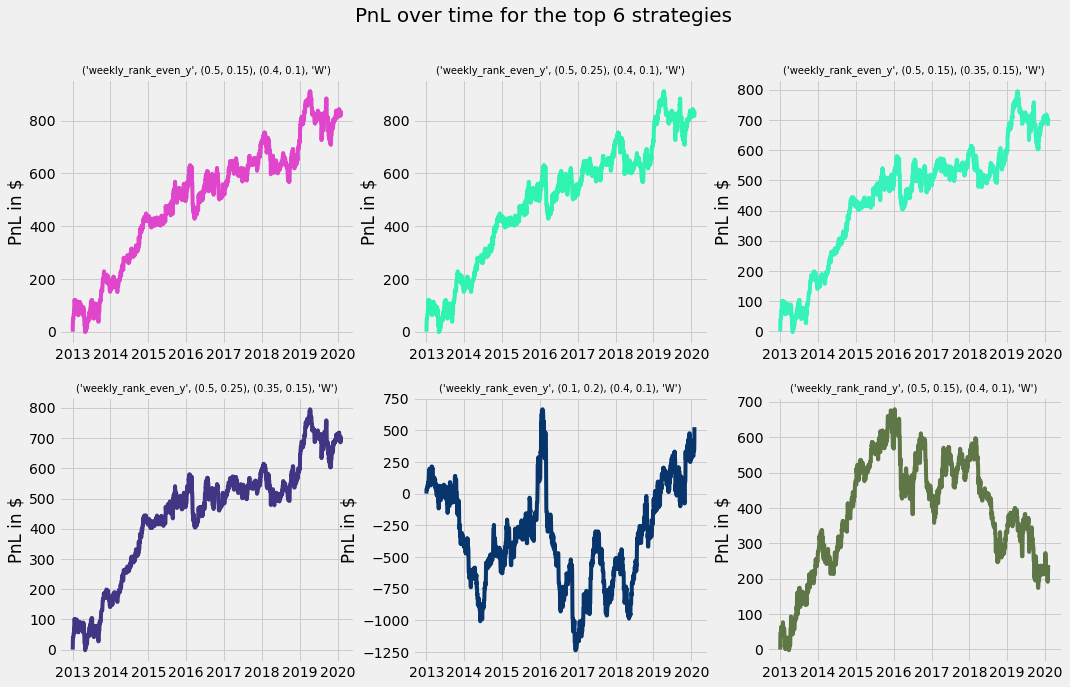

In [188]:
fig, axs = plt.subplots(2,3,figsize=(16,10))
fig.suptitle('PnL over time for the top 6 strategies', fontsize = 20)
x = max_df.index
i = 0 
j = 0 

for idx in largest_pn_idx:
    params = params_arr[idx]
    y =  df_trading_arr[idx][('Portfolio','PnL_accumulated')]
    axs[i,j].plot(x,y, c= np.random.rand(3,))
    axs[i,j].set_ylabel('PnL in $')
    axs[i,j].set_title(str(params), fontsize = 10)
    j+=1 
    if j == 3:
        i += 1
        j = 0 

Interesting observation is that all of them are weekly traded instead of monthly traded, they also all seem to favor putting more weight in the top and bottom quantiles than the middle ones by looking at the second pair of tuples, the first element is the weight in the top and bottom quantile. Five of them is based on equal weighting in the 5 ratios we used and only one of them is based on random allocation in the financial ratios. This might indicate that we are better to weight the ratios evenly but further analysis would be required.

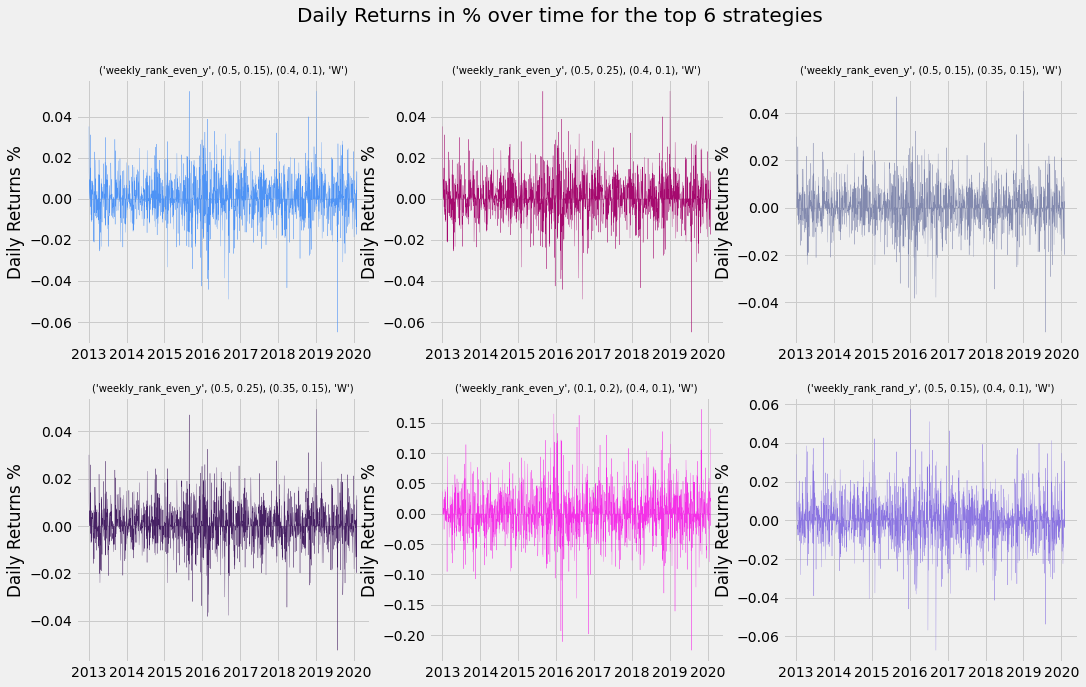

In [235]:
fig, axs = plt.subplots(2,3,figsize=(16,10))
fig.suptitle('Daily Returns in % over time for the top 6 strategies', fontsize = 20)
x = max_df.index
i = 0 
j = 0 

for idx in largest_pn_idx:
    params = params_arr[idx]
    y =  100* (starting_capital + df_trading_arr[idx][('Portfolio','PnL_accumulated')]).pct_change()
    axs[i,j].plot(x,y, c= np.random.rand(3,), lw=0.3)
    axs[i,j].set_ylabel('Daily Returns %')
    axs[i,j].set_title(str(params), fontsize = 10)
    j+=1 
    if j == 3:
        i += 1
        j = 0 

Let's look at some statistics of our returns

18

In [210]:
col = []
for idx in largest_pn_idx:
    params = params_arr[idx]
    s = "Even Q-Dist = {}, D-Distr = {}".format(params[1], params[2])
    if idx == largest_pn_idx[-1]:
        s = "Rand Q-Dist = {}, D-Distr = {}".format(params[1], params[2])
    col.append(s)

stats = pd.DataFrame(data = None, columns = col, index = ['Mean', 'Median', 'Std Dev','1st Quartile', '3rd Quartile', 'Skew', 'Kurtosis'])
stats
for i,idx in enumerate(largest_pn_idx):
    data = (starting_capital + df_trading_arr[idx][('Portfolio','PnL_accumulated')]).pct_change()
    stats[col[i]].loc['Mean'] = data.mean()
    stats[col[i]].loc['Median'] = data.median()
    stats[col[i]].loc['Std Dev'] = data.std()
    stats[col[i]].loc['1st Quartile'] = data.quantile(0.25)
    stats[col[i]].loc['3rd Quartile'] = data.quantile(0.75)
    stats[col[i]].loc['Skew'] = sp.stats.skew(data.dropna())
    stats[col[i]].loc['Kurtosis'] = sp.stats.kurtosis(data.dropna())
stats

,"Even Q-Dist = (0.5, 0.15), D-Distr = (0.4, 0.1)","Even Q-Dist = (0.5, 0.25), D-Distr = (0.4, 0.1)","Even Q-Dist = (0.5, 0.15), D-Distr = (0.35, 0.15)","Even Q-Dist = (0.5, 0.25), D-Distr = (0.35, 0.15)","Even Q-Dist = (0.1, 0.2), D-Distr = (0.4, 0.1)","Rand Q-Dist = (0.5, 0.15), D-Distr = (0.4, 0.1)"
Mean,0.0,0.0,0.0,0.0,0.0,0.0
Median,0.0,0.0,0.0,0.0,0.0,0.0
Std Dev,0.0001,0.0001,0.0001,0.0001,0.0004,0.0001
1st Quartile,-0.0,-0.0,-0.0,-0.0,-0.0002,-0.0
3rd Quartile,0.0001,0.0001,0.0,0.0,0.0002,0.0001
Skew,-0.1555,-0.1555,-0.0584,-0.0584,-0.1601,0.0064
Kurtosis,3.5075,3.5075,3.4221,3.4221,3.9293,3.424


They all seem to exhibit a bit of negative skewness and a bit of kurtosis let's plot to see what it looks like.

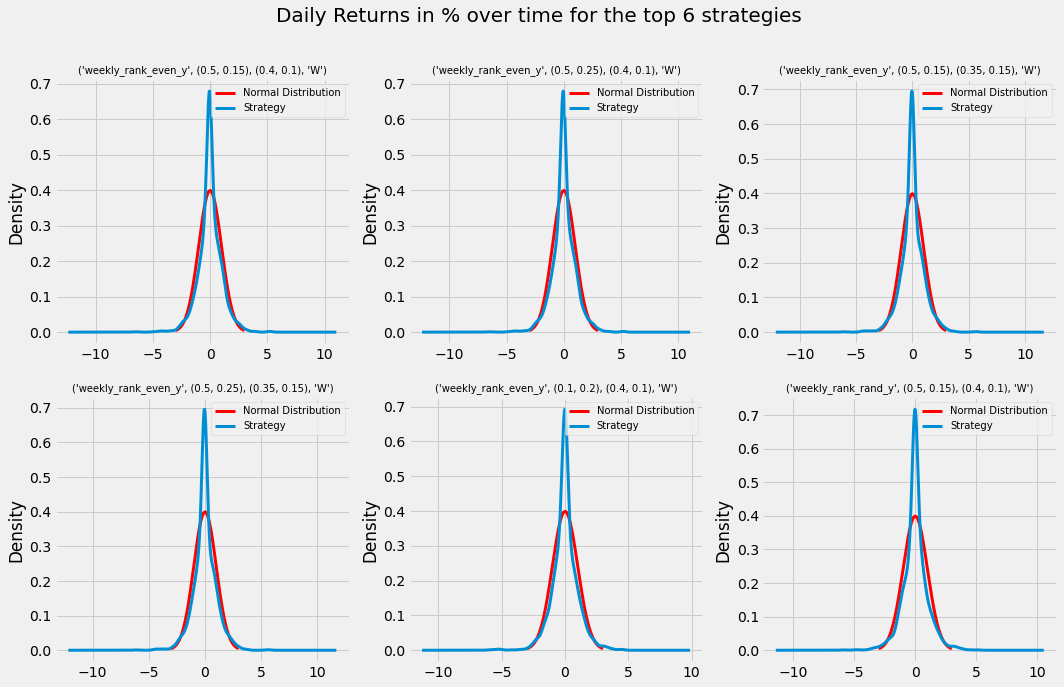

In [233]:
n_x = np.arange(-3,3,0.001)
y = pd.Series(norm.pdf(n_x,0,1), index = n_x, name = 'Normal Distribution')

fig, axs = plt.subplots(2,3,figsize=(16,10))
fig.suptitle('Daily Returns in % over time for the top 6 strategies', fontsize = 20)
x = max_df.index
i = 0 
j = 0 

for idx in largest_pn_idx:
    params = params_arr[idx]
    data = (starting_capital + df_trading_arr[idx][('Portfolio','PnL_accumulated')]).pct_change()
    mean = data.mean()
    std = data.std()
    normalize = (data - mean)/std
    
    axs[i,j].plot(n_x,y, c= 'r', lw=3, label = 'Normal Distribution')
    axs[i,j].set_ylabel('Density')
    normalize.plot.kde(ax=axs[i,j], label = 'Strategy', lw=3)
    axs[i,j].set_title(str(params), fontsize = 10)
    axs[i,j].legend(loc="upper right", fontsize = 10)
    j+=1 
    if j == 3:
        i += 1
        j = 0 

We get similar graphs and we also notice the kurtosis. Let's go back to our best strategy and focus on it.

In [292]:
strat_ret = (starting_capital + df_trading_arr[idx][('Portfolio','PnL_accumulated')]).pct_change()
strat_ret_norm = (strat_ret - strat_ret.mean())/strat_ret.std()
best_pnl = df_trading_arr[np.array(pnl_arr).argmax()][('Portfolio','PnL_accumulated')]

Let's look at the maximum drawdown and maximum gain. The code is baised on Jack Martin-Dryer from HW2 notebook given on Canvas, slightly optmized for less loops and upside as well.

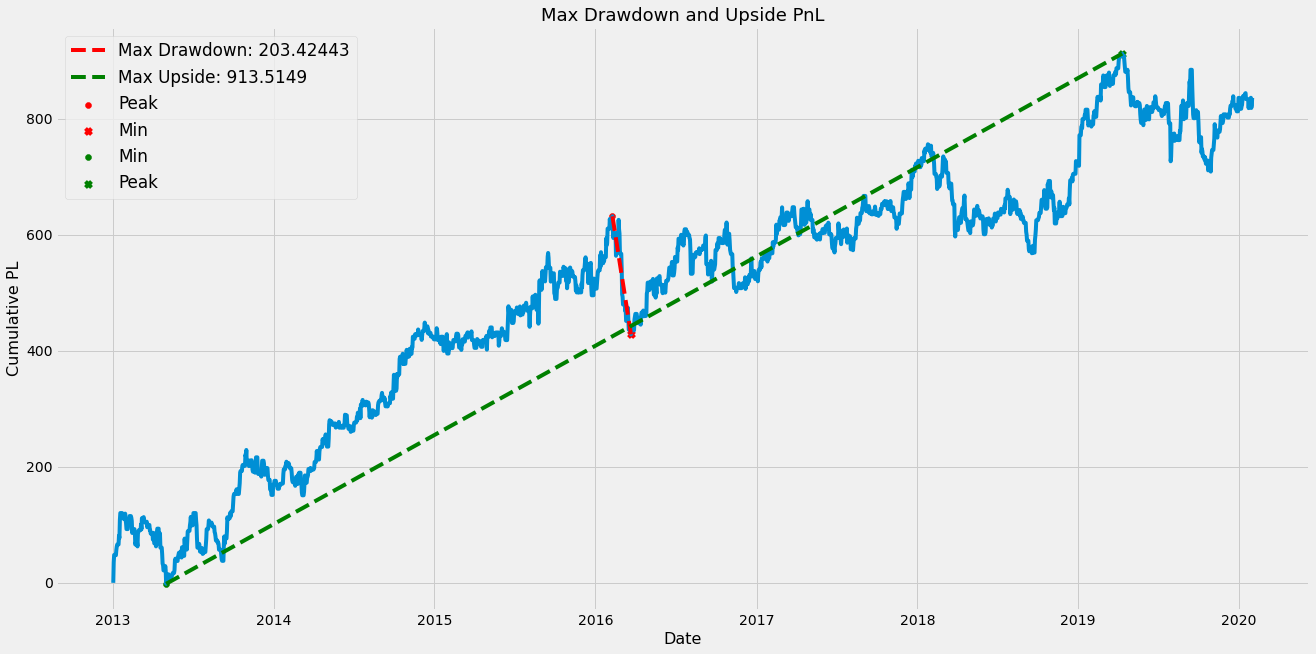

In [287]:
plt.figure(figsize=(20,10))

i = np.argmax(np.maximum.accumulate(best_pnl) - best_pnl) # end of the period
j = np.argmax(best_pnl[:i]) # start of period

plt.plot(best_pnl)

drawdown_start = best_pnl.index[j]
drawdown_end = best_pnl.index[i]

drawdown_peak = best_pnl.iloc[j]
drawdown_min = best_pnl.iloc[i]

plt.scatter(drawdown_start,drawdown_peak, marker='o',color='red',label = 'Peak')
plt.scatter(drawdown_end,drawdown_min, marker='x',color='red',label = 'Min')

date_range = [drawdown_start, drawdown_end]
data_range = [drawdown_peak, drawdown_min]

plt.plot(date_range, data_range, '--', color = 'r',label = 'Max Drawdown: ' + str(round(drawdown,5)))

i = np.argmax(best_pnl - np.minimum.accumulate(best_pnl)) # end of the period
j = np.argmin(best_pnl[:i]) # start of period

upside_start = best_pnl.index[j]
upside_end = best_pnl.index[i]

upside_peak = best_pnl.iloc[i]
upside_min = best_pnl.iloc[j]

upside = upside_peak - upside_min
plt.scatter(upside_start,upside_min, marker='o',color='green',label = 'Min')
plt.scatter(upside_end,upside_peak, marker='x',color='green',label = 'Peak')

date_range = [upside_start, upside_end]
data_range = [upside_min, upside_peak]

plt.plot(date_range, data_range, '--', color ='green', label = 'Max Upside: ' + str(round(upside,5)))

plt.title('Max Drawdown and Upside PnL', size = 18)
plt.ylabel('Cumulative PL', size = 16)
plt.xlabel('Date', size = 16)
plt.legend(fontsize = 'large')
plt.plot()
plt.show()

Let's see if our returns are somewhat normal by running D'Agostino and Pearson's test that tests the null hypothesis that a sample comes from a normal distribution.

In [293]:
print('P-value of the D\'Agostino and Pearson\'s test = {}'.format(sp.stats.normaltest(strat_ret_norm.dropna())[1]))

P-value of the D'Agostino and Pearson's test = 8.104216544164653e-33


We clearly cannot reject the null hypothesis that our returns are not normal.

 Clearly, the p-value is so small that we should reject the null hypothesis that our returns of the spread are normal. Let's look at some time-series analysis and starting with autocorrelation and partial autocorrelation.

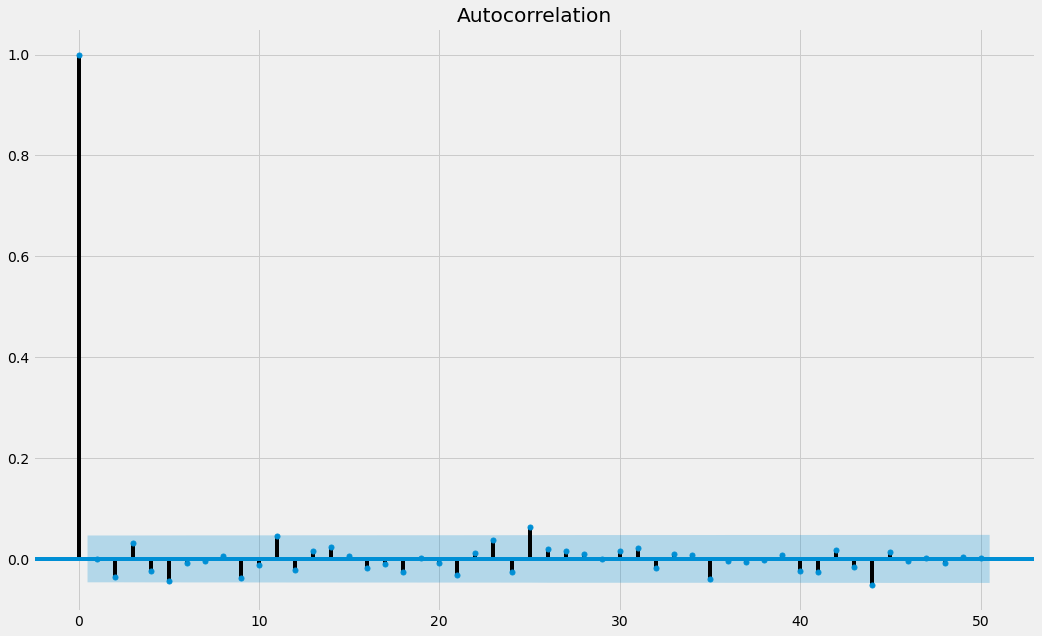

In [294]:
fig1, ax = plt.subplots(figsize=(16,10))
fig1 = sm.graphics.tsa.plot_acf(strat_ret_norm.dropna(), ax = ax, lags = 50)

There doesn't seem to be any autocorrelation. Let's make sure by looking at the PACF.

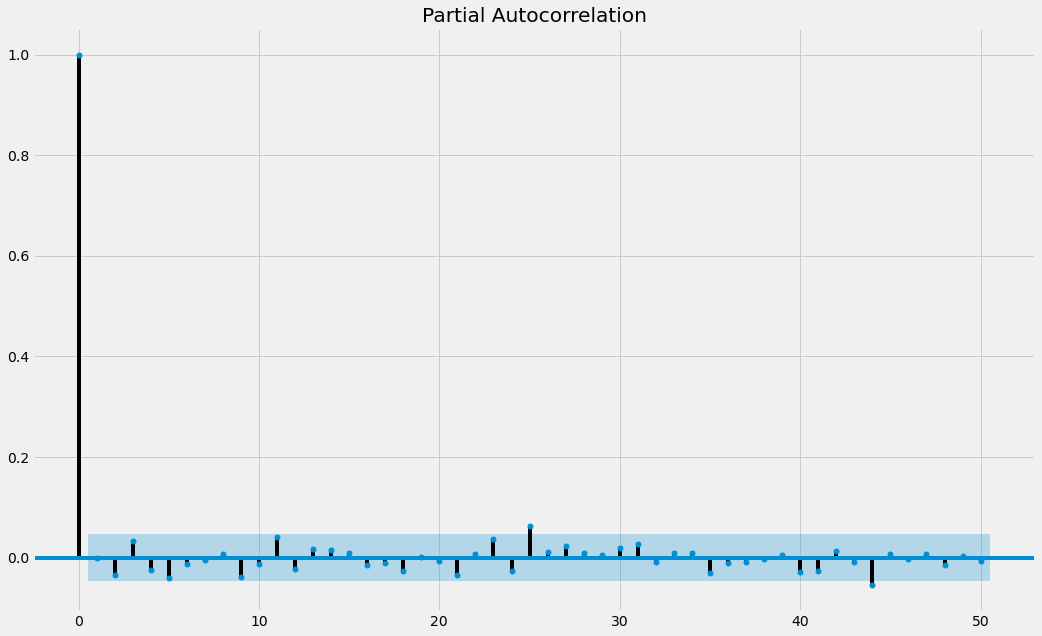

In [295]:
fig1, ax = plt.subplots(figsize=(16,10))
fig1 = sm.graphics.tsa.plot_pacf(strat_ret_norm.dropna(), ax = ax, lags = 50)

As we expected. Let's look for seasonality.

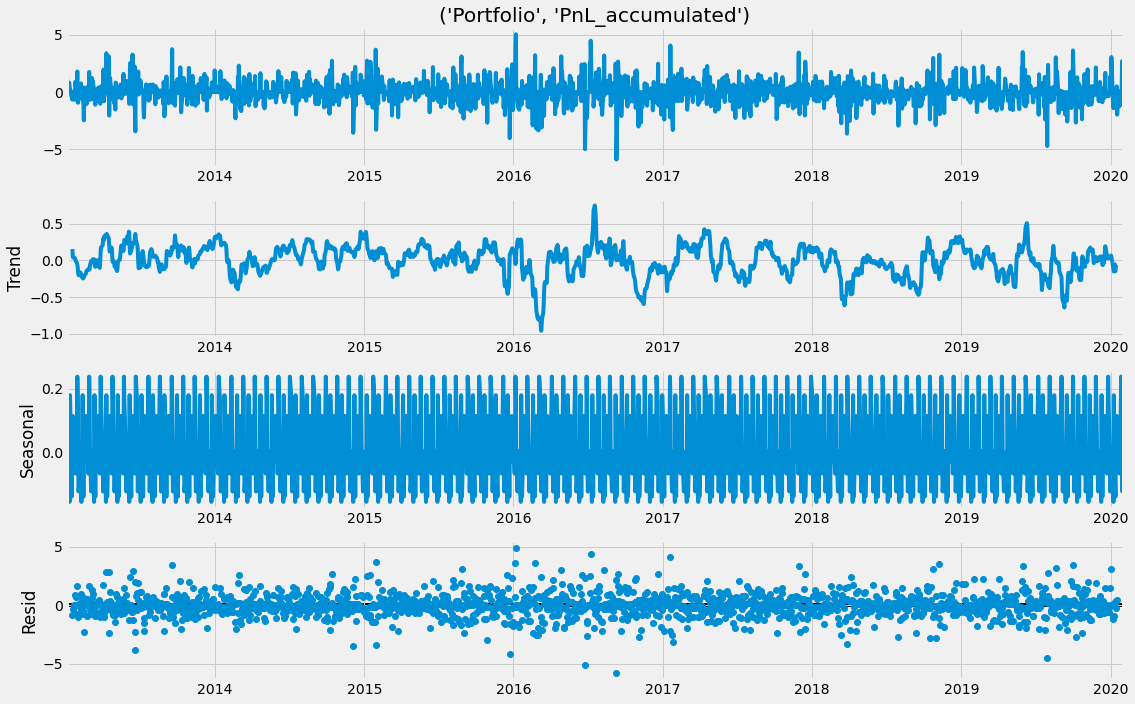

In [296]:
seasonality = sm.tsa.seasonal_decompose(strat_ret_norm.dropna(), model='additive', period=20)
plt.rcParams['figure.figsize'] = [16,10]
seasonality.plot()
plt.show()

Not much can be extracted from that, let's look a little closer at the residual with a QQ plot.

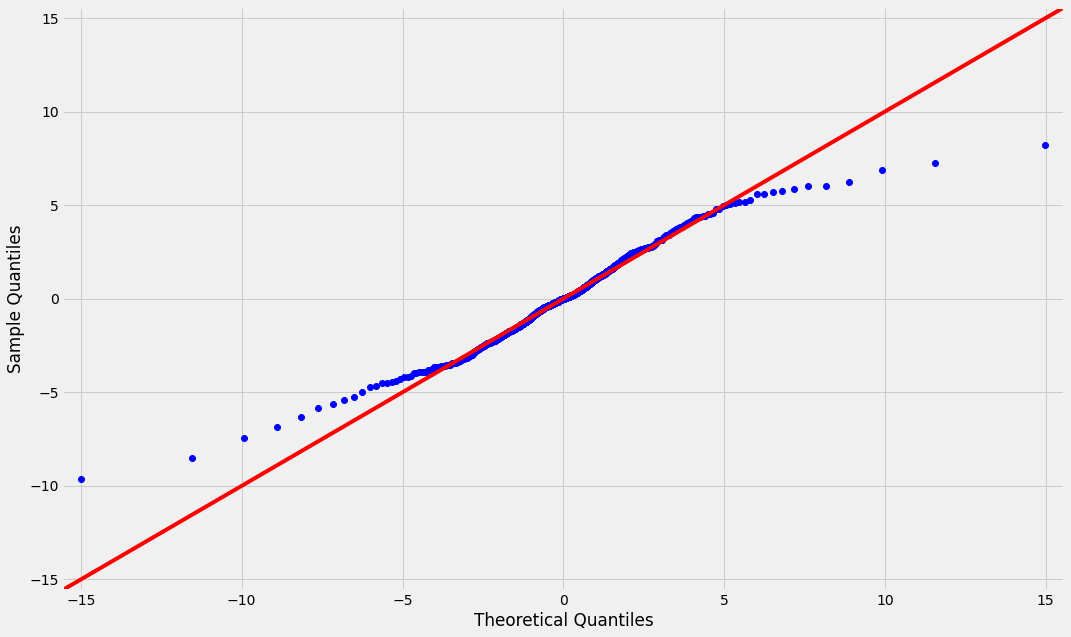

In [298]:
res = seasonality.resid
res = res.fillna(res.mean())
plt.rcParams['figure.figsize'] = [16,10]
fig = sm.qqplot(res, sp.stats.t, fit=True, line="45")
plt.show()

In [299]:
ADF_spread = sm.tsa.stattools.adfuller(res.dropna().values)
print("ADF Stat: {:.4f} \n p-value: {:.4f}".format(ADF_spread[0], ADF_spread[1]))

ADF Stat: -16.7024 
 p-value: 0.0000


From the ADF statistics we cannot reject that the distribution of residuals is not normal but when we look at the QQ plot, we observe a few points that are significantly deviate from what we would explain if the distribution was normal, by not being around the red line. This can be explain from the kurtosis we observed earlier as the deviation from the red line happens in the larger quantiles.

# 6. Comparing with Farma French Factors

In [417]:
ff_path = 'F-F_Research_Data_Factors_daily.CSV'
ff_df = pd.read_csv(ff_path)
ff_df.head()

,Unnamed: 0,Mkt-RF,SMB,HML,RF
0,19260701,0.10,-0.24,-0.28,0.009
1,19260702,0.45,-0.32,-0.08,0.009
2,19260706,0.17,0.27,-0.35,0.009
3,19260707,0.09,-0.59,0.03,0.009
4,19260708,0.21,-0.36,0.15,0.009


In [418]:
start = '2013-01-01'
end = '2020-01-31'
ff_df.rename(columns={'Unnamed: 0':'Date'}, inplace = True)
ff_df['Date'] = pd.to_datetime(ff_df['Date'], format='%Y%m%d')
ff_df = ff_df[(start <= ff_df['Date']) & (ff_df['Date'] <= end)]
ff_df = ff_df.set_index('Date')
ff_df.tail()

,Mkt-RF,SMB,HML,RF
Date,,,,
2020-01-27,-1.56,0.37,-0.42,0.006
2020-01-28,1.02,-0.13,-0.43,0.006
2020-01-29,-0.10,-0.26,-0.96,0.006
2020-01-30,0.34,-0.69,0.63,0.006
2020-01-31,-1.74,-0.43,-0.34,0.006


In [419]:
ff_df['Strat_Ret'] = strat_ret
ff_df['Mkt'] = ff_df['Mkt-RF'] + ff_df['RF']
print(ff_df.isnull().sum().sum())
ff_df.fillna(0)

1


,Mkt-RF,SMB,HML,RF,Strat_Ret,Mkt
Date,,,,,,
2013-01-02,2.62,0.14,0.40,0.000,0.0000e+00,2.620
2013-01-03,-0.14,0.12,0.05,0.000,3.4016e-04,-0.140
2013-01-04,0.55,0.11,0.39,0.000,1.2101e-04,0.550
2013-01-07,-0.31,-0.09,-0.36,0.000,0.0000e+00,-0.310
2013-01-08,-0.27,0.04,-0.01,0.000,-4.9934e-06,-0.270
...,...,...,...,...,...,...
2020-01-27,-1.56,0.37,-0.42,0.006,0.0000e+00,-1.554
2020-01-28,1.02,-0.13,-0.43,0.006,-3.2253e-05,1.026
2020-01-29,-0.10,-0.26,-0.96,0.006,3.0568e-04,-0.094


In [420]:
ff_df.corrwith(ff_df['Strat_Ret']).to_frame().rename_axis("Factors")

,0
Factors,
Mkt-RF,0.0308
SMB,0.0027
HML,0.0013
RF,-0.0433
Strat_Ret,1.0000
Mkt,0.0306


<Figure size 1152x720 with 0 Axes>

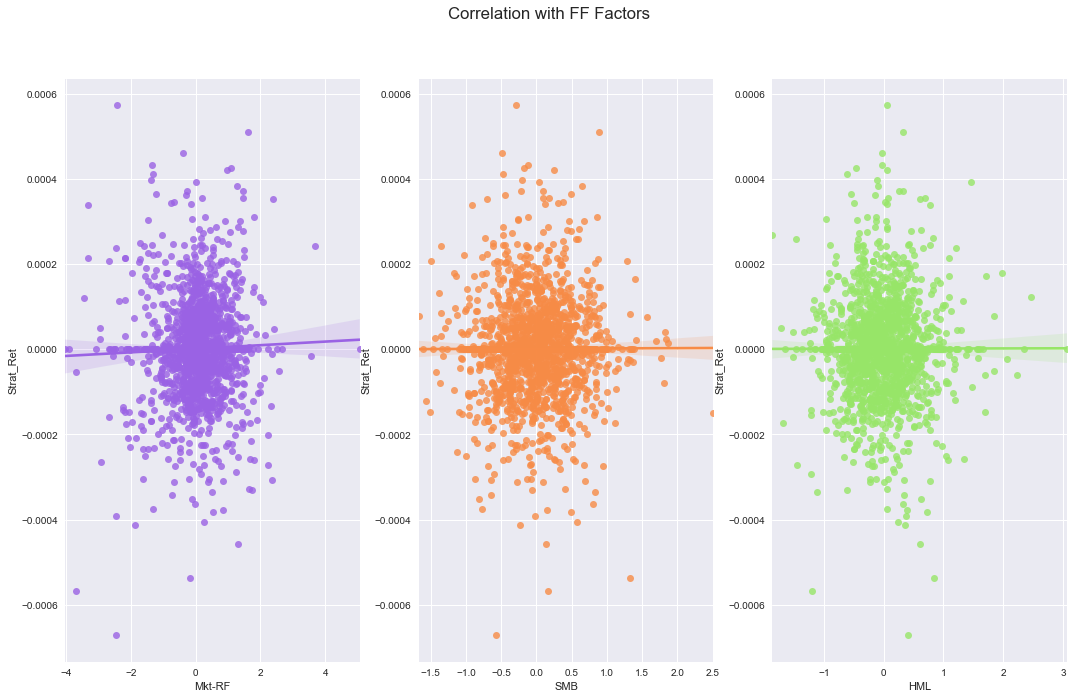

In [382]:
plt.figure()
plt.rcParams['figure.figsize'] = [16,10]
fig, axes = plt.subplots(1,3)
for i in range(3):
    sns.regplot(data = ff_df,y = 'Strat_Ret',x=ff_df.columns[i], ax = axes[i], color= np.random.rand(3,))
plt.suptitle("Correlation with FF Factors")
plt.show()

As we expected from the low correlation with Farma French Factors. Because the PnL is so low, it's not useful to look at portfolio metrics unless we decide to add some leverage to our strategy, we initially start with 1/10th of our capital, let's assume we have a good prime broker and after seeing our PnL and maximum drawdown, he allows us to go 10x leverage, 100 times more capital in the strategy! Let's compute the strategy again and check some metrics such as Sharpe , Sortino and Treynor Ratios.

In [365]:
feat, q, d, freq = max_params
df, *_ = trading_strategy(feat,q,d,freq, 100)

100%|██████████████████████████████████████████████████████████████████████████████| 1783/1783 [10:18<00:00,  2.88it/s]
1783it [00:02, 746.47it/s]


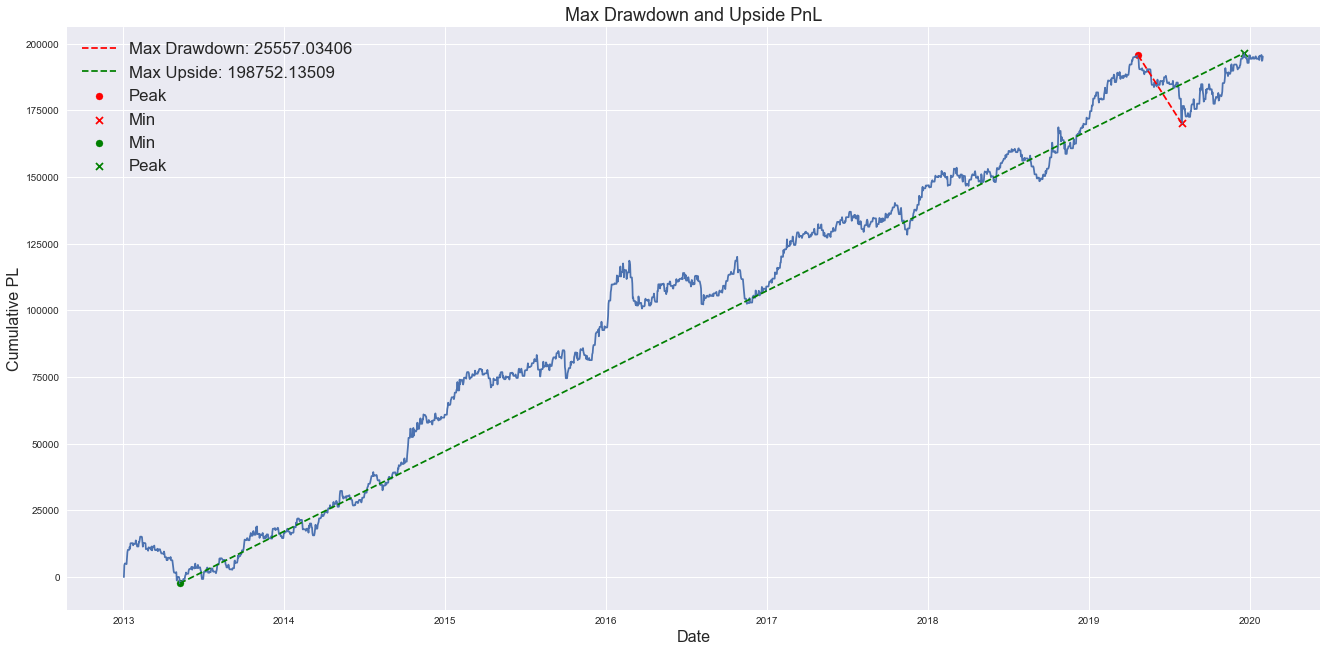

In [421]:
plt.figure(figsize=(20,10))
best_pnl = df[('Portfolio','PnL_accumulated')]
i = np.argmax(np.maximum.accumulate(best_pnl) - best_pnl) # end of the period
j = np.argmax(best_pnl[:i]) # start of period

plt.plot(best_pnl)

drawdown_start = best_pnl.index[j]
drawdown_end = best_pnl.index[i]

drawdown_peak = best_pnl.iloc[j]
drawdown_min = best_pnl.iloc[i]

drawdown = drawdown_peak - drawdown_min

plt.scatter(drawdown_start,drawdown_peak, marker='o',color='red',label = 'Peak')
plt.scatter(drawdown_end,drawdown_min, marker='x',color='red',label = 'Min')

date_range = [drawdown_start, drawdown_end]
data_range = [drawdown_peak, drawdown_min]

plt.plot(date_range, data_range, '--', color = 'r',label = 'Max Drawdown: ' + str(round(drawdown,5)))

i = np.argmax(best_pnl - np.minimum.accumulate(best_pnl)) # end of the period
j = np.argmin(best_pnl[:i]) # start of period

upside_start = best_pnl.index[j]
upside_end = best_pnl.index[i]

upside_peak = best_pnl.iloc[i]
upside_min = best_pnl.iloc[j]

upside = upside_peak - upside_min
plt.scatter(upside_start,upside_min, marker='o',color='green',label = 'Min')
plt.scatter(upside_end,upside_peak, marker='x',color='green',label = 'Peak')

date_range = [upside_start, upside_end]
data_range = [upside_min, upside_peak]

plt.plot(date_range, data_range, '--', color ='green', label = 'Max Upside: ' + str(round(upside,5)))

plt.title('Max Drawdown and Upside PnL', size = 18)
plt.ylabel('Cumulative PL', size = 16)
plt.xlabel('Date', size = 16)
plt.legend(fontsize = 'large')
plt.plot()
plt.show()

In [422]:
ff_df['Strat_ret_lev_100'] = (starting_capital + df[('Portfolio','PnL_accumulated')]).pct_change()

In [423]:
(ff_df['Strat_ret_lev_100']+1).cumprod()

Date
2013-01-02       NaN
2013-01-03    1.0442
2013-01-04    1.0506
2013-01-07    1.0506
2013-01-08    1.0484
               ...  
2020-01-27    2.9541
2020-01-28    2.9572
2020-01-29    2.9352
2020-01-30    2.9374
2020-01-31    2.9514
Name: Strat_ret_lev_100, Length: 1783, dtype: float64

In [424]:
(1+ff_df["RF"]).cumprod()

Date
2013-01-02      1.0000
2013-01-03      1.0000
2013-01-04      1.0000
2013-01-07      1.0000
2013-01-08      1.0000
                ...   
2020-01-27    151.4805
2020-01-28    152.3894
2020-01-29    153.3037
2020-01-30    154.2235
2020-01-31    155.1489
Name: RF, Length: 1783, dtype: float64

Something is up here, we wouldn't expect the daily compounded risk-free rate to accumulate to 154x in the spam of ~7 years. This means that the dataframe is in basis point. Let's devide the RF by 100.

In [425]:
ff_df["RF"] /= 100
(1+ff_df["RF"]).cumprod()

Date
2013-01-02    1.0000
2013-01-03    1.0000
2013-01-04    1.0000
2013-01-07    1.0000
2013-01-08    1.0000
               ...  
2020-01-27    1.0517
2020-01-28    1.0517
2020-01-29    1.0518
2020-01-30    1.0519
2020-01-31    1.0519
Name: RF, Length: 1783, dtype: float64

This makes a lot more sense considering how low the risk-free rate was for multiple years and only start rising in last 2010's. 

In [438]:
ff_df = ff_df.dropna()
#sharpe ratio, sortino ratio, and treynor ratio
Sharpe_Ratio = np.sqrt(252)*(ff_df['Strat_ret_lev_100'] - ff_df["RF"]).mean()/ff_df['Strat_ret_lev_100'].std()
Sortino_Ratio  = np.sqrt(252)*(ff_df['Strat_ret_lev_100'] - ff_df["RF"]).mean()/ (np.sqrt(ff_df['Strat_ret_lev_100'][ff_df['Strat_ret_lev_100']<0]**2).sum()/len(ff_df['Strat_ret_lev_100']))
Treynor_Ratio = 252*(ff_df['Strat_ret_lev_100'] - ff_df["RF"]).mean()/np.corrcoef(ff_df['Strat_ret_lev_100'],ff_df['Mkt-RF'])[0][1]
pd.Series({'Sharpe_Ratio':Sharpe_Ratio,'Sortino_Ratio':Sortino_Ratio,'Treynor_Ratio':Treynor_Ratio}).to_frame()

,0
Sharpe_Ratio,1.4840
Sortino_Ratio,5.2371
Treynor_Ratio,-2.5284


One thing to consider before evaluating the strategy ratios, is to understand that due to a lack of time, I did not take into account margin requirements and didn't do enough safety checks around leverage to make sure I coded it properly and that if the amount of cash needed to finance the levered strategy was properly taken into account. Let's look at the Downside Beta, considering how high the Sortino Ratio is versus the Sharpe Ratio, we expect to a weak negative beta.

In [357]:
downmkt_df = ff_df[ff_df['Mkt-RF'] + ff_df['RF'] < 0]
y = downmkt_df['Strat_ret_lev_100']
x = sm.add_constant(downmkt_df['Mkt-RF'])

downside_beta = sm.OLS(y, x).fit().params.to_frame('Downside Beta Regression')
downside_beta.loc['R${^2}$'] = sm.OLS(y, x).fit().rsquared

downside_beta

,Downside Beta Regression
const,0.0004
Mkt-RF,-0.0010
R${^2}$,0.0104


There appears to me no relationship between the strategy's performance and when the market is down, as our $R{^2}$ value is very small. Let's look at the regular beta and cumulative returns of our strategy versus market returns.

In [434]:
y = ff_df['Strat_ret_lev_100'].fillna(0)
x = sm.add_constant(ff_df['Mkt-RF'])

beta = sm.OLS(y, x).fit().params.to_frame('Beta Regression')
beta.loc['R${^2}$'] = sm.OLS(y, x).fit().rsquared

beta

,Beta Regression
const,0.0007
Mkt-RF,-0.0005
R${^2}$,0.0036


Seems like there is little correlation between the two.

In [426]:
ff_df['Mkt'] /= 100

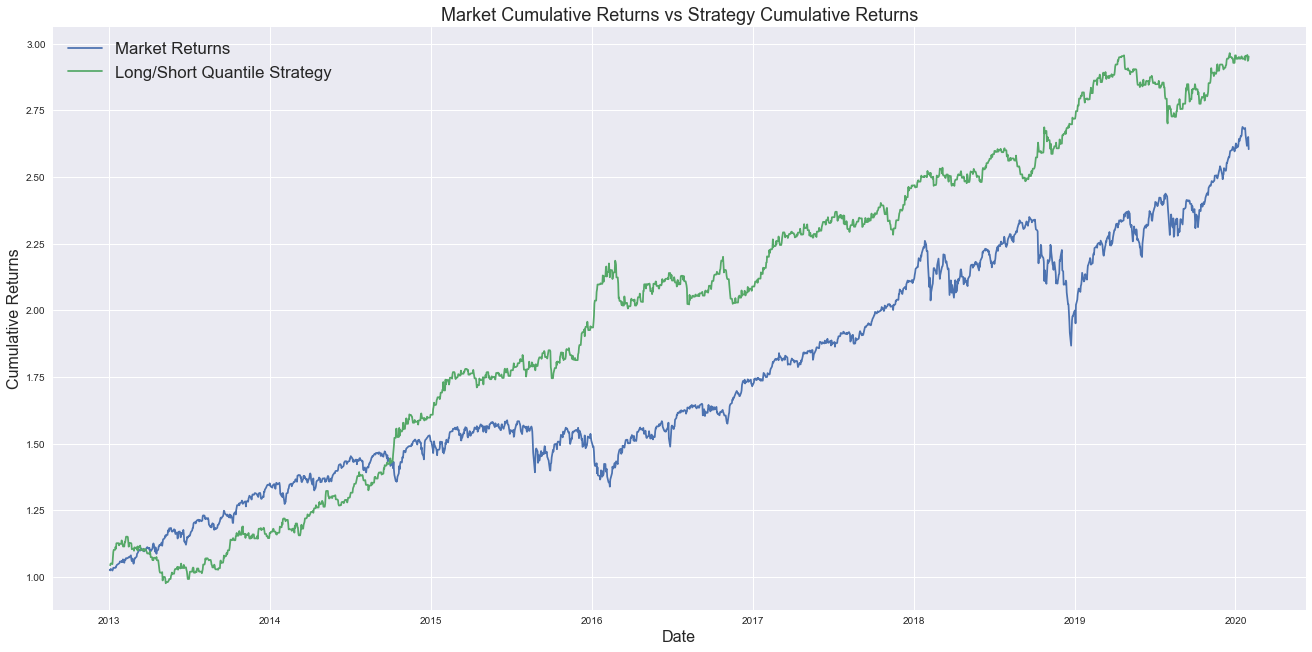

In [427]:
plt.figure(figsize=(20,10))

plt.plot((1+ff_df['Mkt']).cumprod(), label = 'Market Returns')
plt.plot((1+ff_df['Strat_ret_lev_100']).cumprod(), label = 'Long/Short Quantile Strategy')

plt.title('Market Cumulative Returns vs Strategy Cumulative Returns', size = 18)
plt.ylabel('Cumulative Returns', size = 16)
plt.xlabel('Date', size = 16)
plt.legend(fontsize = 'large')
plt.plot()
plt.show()

The strategy seems to be doing better than the market returns in downtime if we pay attention to 2016 and 2019. This is a very interesting result. More analysis could be done, but we'll leave it at that for now. Considering how leveraged we are, this is definitely a big concern but we made sure that we short as much capital as we are long so where this strategy might break is that if some of the correlations between the securities brake down heavily during a period of crisis and the short positions don't fall as much as the securities we are long. We might break. One thing to notice is that the maximum drawdown is 25k while our capital is 100k so it does look like we can substain a shock but bad market timing with a previously unseen event could break the strategy at it's early stage.